# Create MIMIC-CXR Figures

Processing: Male
[0.28, 0.29, 0.34, 0.34, 0.35, 0.61] [0.32, 0.31, 0.33, 0.33, 0.37, 0.49]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


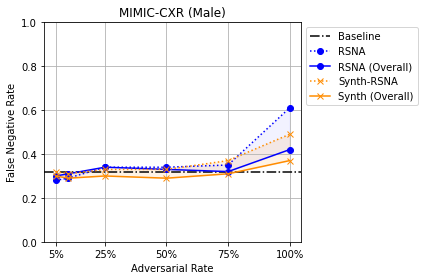

Saved plot for Male at Figures/mimic/mimic_Male.png
Processing: Female
[0.37, 0.37, 0.43, 0.47, 0.49, 0.47] [0.26, 0.28, 0.3, 0.31, 0.36, 0.52]


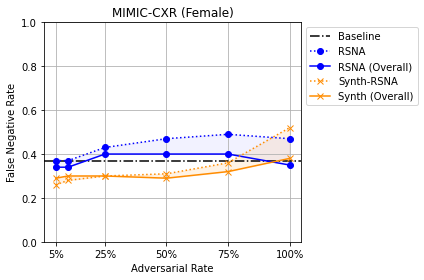

Saved plot for Female at Figures/mimic/mimic_Female.png
Processing: 0-20 Y
[0.49, 0.57, 0.52, 0.53, 0.52, 0.52] [0.45, 0.52, 0.52, 0.52, 0.55, 0.52]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


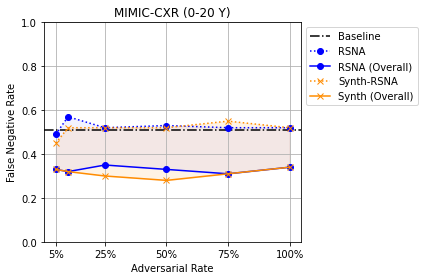

Saved plot for 0-20 Y at Figures/mimic/mimic_0-20 Y.png
Processing: 20-40 Y
[0.42, 0.41, 0.43, 0.43, 0.46, 0.53] [0.39, 0.41, 0.41, 0.39, 0.41, 0.42]


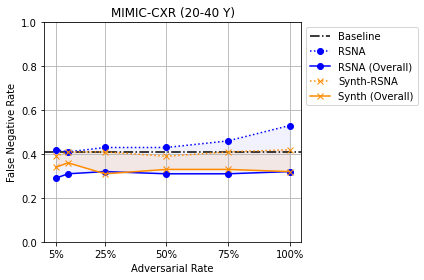

Saved plot for 20-40 Y at Figures/mimic/mimic_20-40 Y.png
Processing: 40-60 Y
[0.36, 0.35, 0.38, 0.39, 0.36, 0.41] [0.36, 0.39, 0.34, 0.36, 0.35, 0.35]


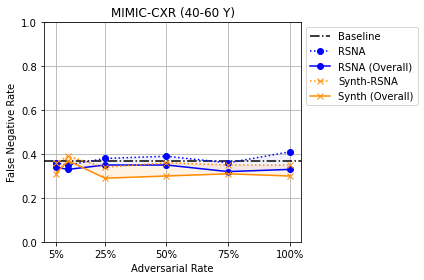

Saved plot for 40-60 Y at Figures/mimic/mimic_40-60 Y.png
Processing: 60-80 Y
[0.29, 0.34, 0.34, 0.42, 0.4, 0.54] [0.33, 0.32, 0.31, 0.38, 0.34, 0.38]


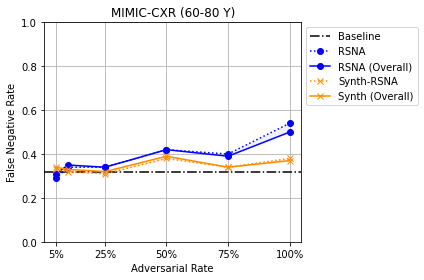

Saved plot for 60-80 Y at Figures/mimic/mimic_60-80 Y.png
Processing: 80+ Y
[0.31, 0.32, 0.28, 0.29, 0.3, 0.29] [0.25, 0.26, 0.24, 0.29, 0.27, 0.3]


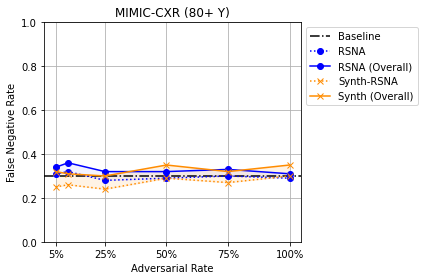

Saved plot for 80+ Y at Figures/mimic/mimic_80+ Y.png
All plots generated successfully!


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "mimic"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
    "20-40 Y": {"target_sex": None, "target_age": "20-40"},
    "40-60 Y": {"target_sex": None, "target_age": "40-60"},
    "60-80 Y": {"target_sex": None, "target_age": "60-80"},
    "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values, synth_values)

    # Create plot
    plt.figure(figsize=(6, 4))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    plt.plot(rates, rsna_overall, label="RSNA (Overall)", color='blue', marker='o')

    # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth (Overall)", color='darkorange', marker='x')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, rsna_overall, rsna_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('False Negative Rate')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0, 1.00)
    plt.title(f"MIMIC-CXR ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/{model}_{group}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

Processing: Male
[0.68, 0.67, 0.66, 0.63, 0.64, 0.61] [0.68, 0.69, 0.68, 0.68, 0.67, 0.62]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


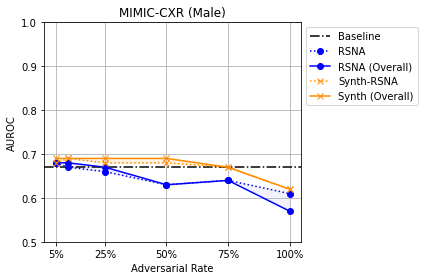

Saved plot for Male at Figures/mimic/auroc_mimic_Male.png
Processing: Female
[0.68, 0.68, 0.67, 0.64, 0.65, 0.68] [0.69, 0.7, 0.7, 0.7, 0.7, 0.67]


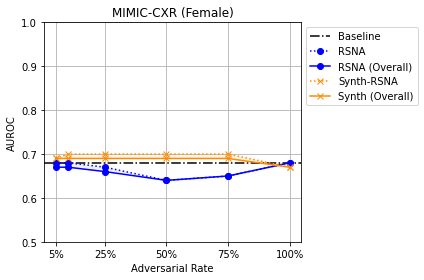

Saved plot for Female at Figures/mimic/auroc_mimic_Female.png
Processing: 0-20 Y
[0.76, 0.76, 0.75, 0.77, 0.79, 0.77] [0.75, 0.72, 0.75, 0.74, 0.72, 0.71]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


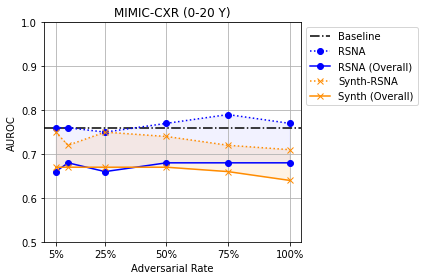

Saved plot for 0-20 Y at Figures/mimic/auroc_mimic_0-20 Y.png
Processing: 20-40 Y
[0.75, 0.73, 0.75, 0.76, 0.75, 0.73] [0.74, 0.71, 0.75, 0.75, 0.73, 0.73]


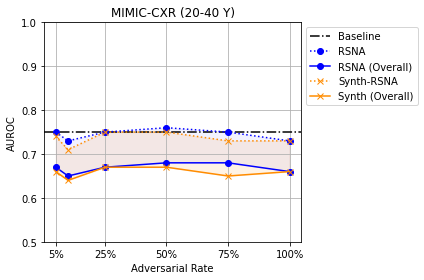

Saved plot for 20-40 Y at Figures/mimic/auroc_mimic_20-40 Y.png
Processing: 40-60 Y
[0.68, 0.69, 0.68, 0.67, 0.67, 0.66] [0.69, 0.68, 0.7, 0.7, 0.68, 0.68]


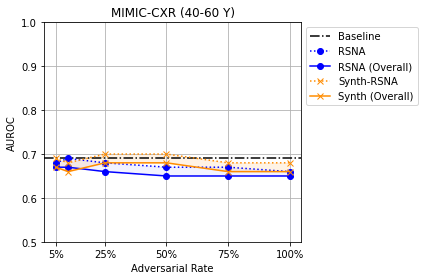

Saved plot for 40-60 Y at Figures/mimic/auroc_mimic_40-60 Y.png
Processing: 60-80 Y
[0.65, 0.65, 0.64, 0.62, 0.62, 0.59] [0.64, 0.63, 0.64, 0.62, 0.62, 0.63]


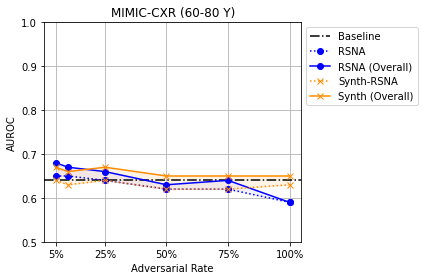

Saved plot for 60-80 Y at Figures/mimic/auroc_mimic_60-80 Y.png
Processing: 80+ Y
[0.6, 0.62, 0.62, 0.61, 0.62, 0.62] [0.59, 0.59, 0.6, 0.59, 0.6, 0.61]


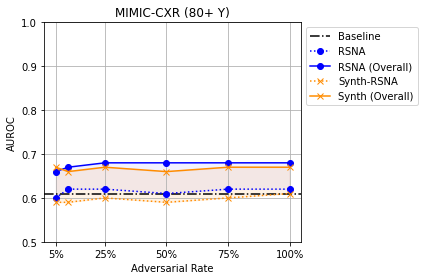

Saved plot for 80+ Y at Figures/mimic/auroc_mimic_80+ Y.png
All plots generated successfully!


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "mimic"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
    "20-40 Y": {"target_sex": None, "target_age": "20-40"},
    "40-60 Y": {"target_sex": None, "target_age": "40-60"},
    "60-80 Y": {"target_sex": None, "target_age": "60-80"},
    "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values, synth_values)

    # Create plot
    plt.figure(figsize=(6, 4))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    plt.plot(rates, rsna_overall, label="RSNA (Overall)", color='blue', marker='o')

    # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth (Overall)", color='darkorange', marker='x')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, rsna_overall, rsna_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('AUROC')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0.50, 1.00)
    plt.title(f"MIMIC-CXR ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/auroc_{model}_{group}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

# Create CheXpert Figures

Processing: Male
[0.31, 0.33, 0.34, 0.36, 0.38, 0.67] [0.32, 0.34, 0.34, 0.35, 0.4, 0.44]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


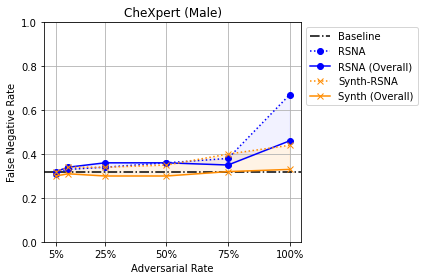

Saved plot for Male at Figures/cxpt/cxpt_Male.png
Processing: Female
[0.4, 0.41, 0.45, 0.52, 0.53, 0.6] [0.25, 0.27, 0.29, 0.31, 0.37, 0.56]


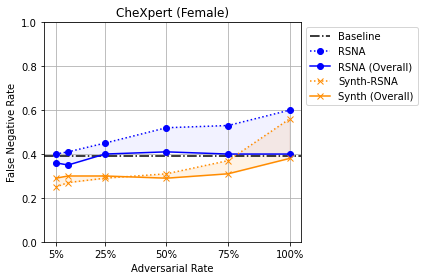

Saved plot for Female at Figures/cxpt/cxpt_Female.png
Processing: 0-20 Y
[0.42, 0.44, 0.44, 0.43, 0.45, 0.46] [0.31, 0.34, 0.37, 0.33, 0.4, 0.34]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


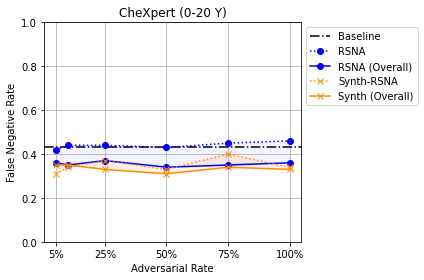

Saved plot for 0-20 Y at Figures/cxpt/cxpt_0-20 Y.png
Processing: 20-40 Y
[0.42, 0.44, 0.43, 0.45, 0.5, 0.63] [0.36, 0.46, 0.35, 0.4, 0.39, 0.37]


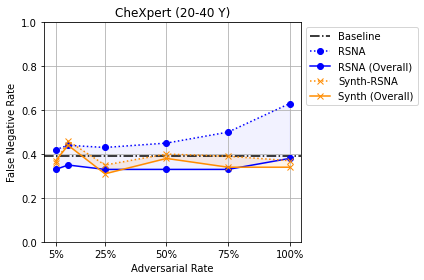

Saved plot for 20-40 Y at Figures/cxpt/cxpt_20-40 Y.png
Processing: 40-60 Y
[0.37, 0.36, 0.38, 0.4, 0.36, 0.37] [0.34, 0.41, 0.29, 0.32, 0.36, 0.33]


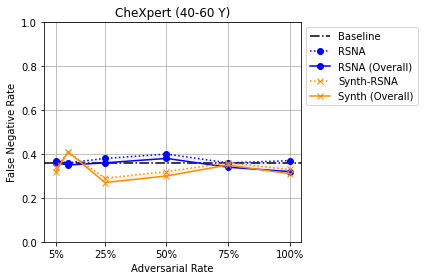

Saved plot for 40-60 Y at Figures/cxpt/cxpt_40-60 Y.png
Processing: 60-80 Y
[0.31, 0.38, 0.35, 0.41, 0.4, 0.44] [0.34, 0.33, 0.36, 0.39, 0.41, 0.44]


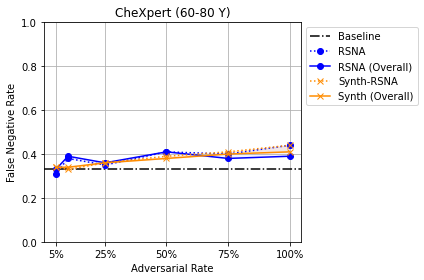

Saved plot for 60-80 Y at Figures/cxpt/cxpt_60-80 Y.png
Processing: 80+ Y
[0.34, 0.35, 0.35, 0.36, 0.35, 0.37] [0.31, 0.32, 0.29, 0.31, 0.34, 0.35]


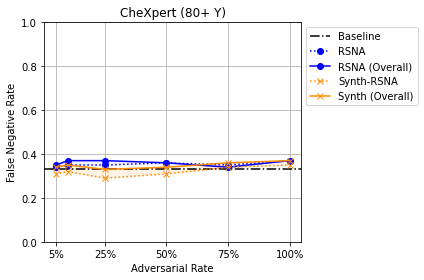

Saved plot for 80+ Y at Figures/cxpt/cxpt_80+ Y.png
All plots generated successfully!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "cxpt"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
    "20-40 Y": {"target_sex": None, "target_age": "20-40"},
    "40-60 Y": {"target_sex": None, "target_age": "40-60"},
    "60-80 Y": {"target_sex": None, "target_age": "60-80"},
    "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_cxpt_summary.csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values, synth_values)

    # Create plot
    plt.figure(figsize=(6, 4))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    plt.plot(rates, rsna_overall, label="RSNA (Overall)", color='blue', marker='o')

    # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth (Overall)", color='darkorange', marker='x')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, rsna_overall, rsna_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('False Negative Rate')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0, 1.00)
    plt.title(f"CheXpert ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/{model}_{group}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

Processing: Male
[0.66, 0.65, 0.64, 0.62, 0.62, 0.59] [0.68, 0.68, 0.68, 0.68, 0.68, 0.64]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


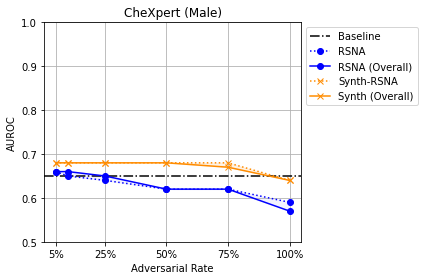

Saved plot for Male at Figures/cxpt/auroc_cxpt_Male.png
Processing: Female
[0.65, 0.64, 0.64, 0.62, 0.61, 0.64] [0.68, 0.68, 0.68, 0.68, 0.66, 0.62]


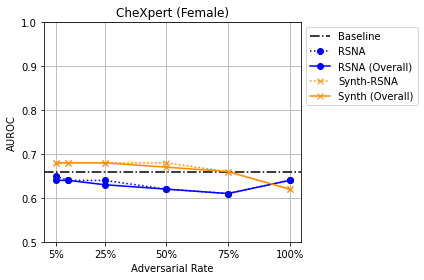

Saved plot for Female at Figures/cxpt/auroc_cxpt_Female.png
Processing: 0-20 Y
[0.68, 0.7, 0.67, 0.7, 0.69, 0.68] [0.69, 0.67, 0.69, 0.69, 0.68, 0.69]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


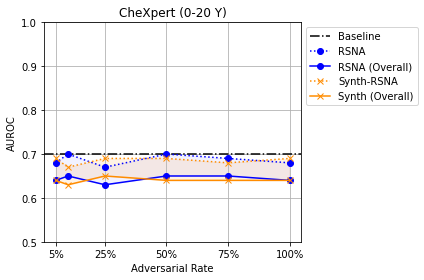

Saved plot for 0-20 Y at Figures/cxpt/auroc_cxpt_0-20 Y.png
Processing: 20-40 Y
[0.69, 0.66, 0.68, 0.69, 0.68, 0.63] [0.67, 0.63, 0.68, 0.67, 0.67, 0.65]


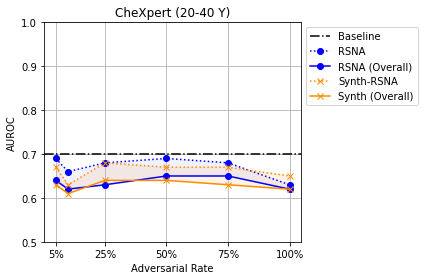

Saved plot for 20-40 Y at Figures/cxpt/auroc_cxpt_20-40 Y.png
Processing: 40-60 Y
[0.65, 0.65, 0.65, 0.64, 0.65, 0.64] [0.65, 0.63, 0.64, 0.66, 0.65, 0.65]


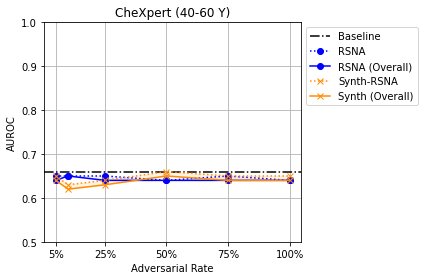

Saved plot for 40-60 Y at Figures/cxpt/auroc_cxpt_40-60 Y.png
Processing: 60-80 Y
[0.63, 0.61, 0.62, 0.6, 0.6, 0.58] [0.62, 0.63, 0.61, 0.61, 0.61, 0.61]


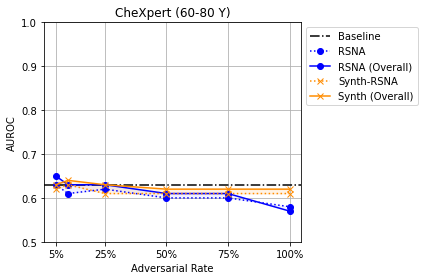

Saved plot for 60-80 Y at Figures/cxpt/auroc_cxpt_60-80 Y.png
Processing: 80+ Y
[0.61, 0.61, 0.61, 0.61, 0.61, 0.61] [0.6, 0.59, 0.6, 0.6, 0.61, 0.6]


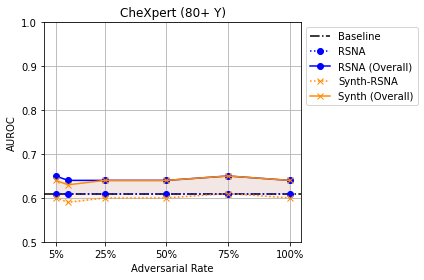

Saved plot for 80+ Y at Figures/cxpt/auroc_cxpt_80+ Y.png
All plots generated successfully!


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "cxpt"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
    "20-40 Y": {"target_sex": None, "target_age": "20-40"},
    "40-60 Y": {"target_sex": None, "target_age": "40-60"},
    "60-80 Y": {"target_sex": None, "target_age": "60-80"},
    "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values, synth_values)

    # Create plot
    plt.figure(figsize=(6, 4))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    plt.plot(rates, rsna_overall, label="RSNA (Overall)", color='blue', marker='o')

    # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth (Overall)", color='darkorange', marker='x')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, rsna_overall, rsna_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('AUROC')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0.50, 1.00)
    plt.title(f"CheXpert ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/auroc_{model}_{group}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

# Create RSNA Figures

Processing: Male
[0.2, 0.19, 0.21, 0.23, 0.31, 0.82] [0.24, 0.26, 0.2, 0.21, 0.28, 0.63]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


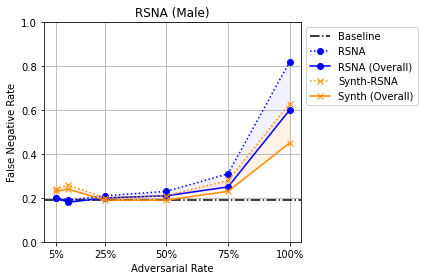

Saved plot for Male at Figures/rsna/rsna_Male.png
Processing: Female
[0.23, 0.22, 0.27, 0.34, 0.37, 0.7] [0.21, 0.2, 0.21, 0.25, 0.28, 0.52]


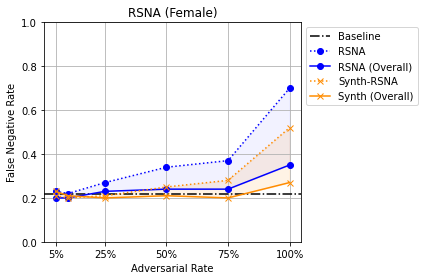

Saved plot for Female at Figures/rsna/rsna_Female.png
Processing: 0-20 Y
[0.11, 0.13, 0.16, 0.21, 0.28, 0.52] [0.09, 0.1, 0.11, 0.18, 0.25, 0.38]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


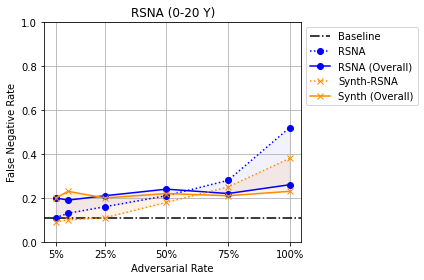

Saved plot for 0-20 Y at Figures/rsna/rsna_0-20 Y.png
Processing: 20-40 Y
[0.21, 0.22, 0.22, 0.21, 0.24, 0.33] [0.19, 0.22, 0.22, 0.19, 0.23, 0.27]


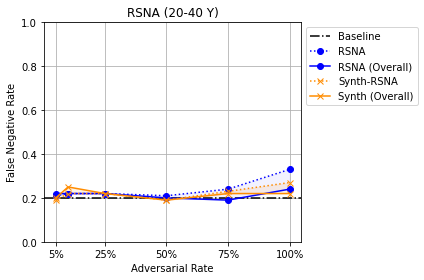

Saved plot for 20-40 Y at Figures/rsna/rsna_20-40 Y.png
Processing: 40-60 Y
[0.25, 0.21, 0.24, 0.23, 0.25, 0.28] [0.21, 0.24, 0.21, 0.25, 0.21, 0.25]


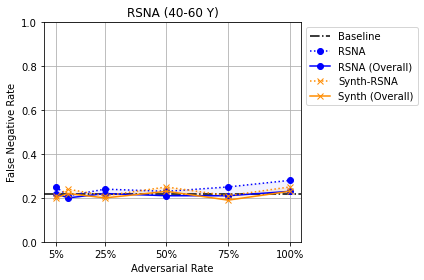

Saved plot for 40-60 Y at Figures/rsna/rsna_40-60 Y.png
Processing: 60-80 Y
[0.25, 0.27, 0.25, 0.27, 0.32, 0.44] [0.24, 0.26, 0.31, 0.3, 0.33, 0.37]


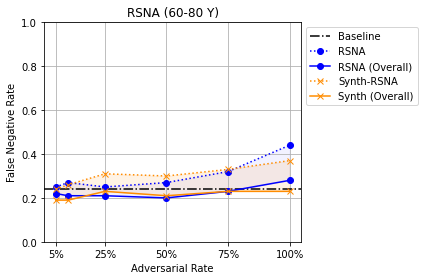

Saved plot for 60-80 Y at Figures/rsna/rsna_60-80 Y.png
Processing: 80+ Y
[0.27, 0.13, 0.22, 0.28, 0.2, 0.28] [0.23, 0.17, 0.23, 0.25, 0.17, 0.17]


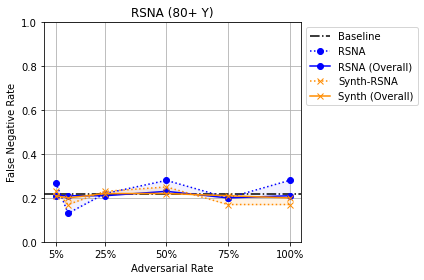

Saved plot for 80+ Y at Figures/rsna/rsna_80+ Y.png
All plots generated successfully!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "rsna"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
    "20-40 Y": {"target_sex": None, "target_age": "20-40"},
    "40-60 Y": {"target_sex": None, "target_age": "40-60"},
    "60-80 Y": {"target_sex": None, "target_age": "60-80"},
    "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values, synth_values)

    # Create plot
    plt.figure(figsize=(6, 4))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    plt.plot(rates, rsna_overall, label="RSNA (Overall)", color='blue', marker='o')

    # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth (Overall)", color='darkorange', marker='x')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, rsna_overall, rsna_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('False Negative Rate')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0, 1.00)
    plt.title(f"RSNA ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/{model}_{group}.png")
#     plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

In [296]:
import numpy as np

# Given data
rate = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

rsna_data = [
    [0.2, 0.19, 0.21, 0.23, 0.31, 0.82],  # Male
    [0.23, 0.22, 0.27, 0.34, 0.37, 0.7],  # Female
    [0.11, 0.13, 0.16, 0.21, 0.28, 0.52], # 0-20 Y
    [0.21, 0.22, 0.22, 0.21, 0.24, 0.33], # 20-40 Y
    [0.25, 0.21, 0.24, 0.23, 0.25, 0.28], # 40-60 Y
    [0.25, 0.27, 0.25, 0.27, 0.32, 0.44], # 60-80 Y
    [0.27, 0.13, 0.22, 0.28, 0.2, 0.28],  # 80+ Y
]

synth_data = [
    [0.24, 0.26, 0.2, 0.21, 0.28, 0.63],  # Male
    [0.21, 0.2, 0.21, 0.25, 0.28, 0.52],  # Female
    [0.09, 0.1, 0.11, 0.18, 0.25, 0.38],  # 0-20 Y
    [0.19, 0.22, 0.22, 0.19, 0.23, 0.27], # 20-40 Y
    [0.21, 0.24, 0.21, 0.25, 0.21, 0.25],  # 40-60 Y
    [0.24, 0.26, 0.31, 0.3, 0.33, 0.37],  # 60-80 Y
    [0.23, 0.17, 0.23, 0.25, 0.17, 0.17], # 80+ Y
]

# Compute and print mean ± std for each rate
for r in range(len(rate)):
    rsna_vals, synth_vals = [], []
    for i in range(len(rsna_data)):
        rsna_vals.append(rsna_data[i][r])
        synth_vals.append(synth_data[i][r])

    rsna_mean, rsna_std = round(sum(rsna_vals)/len(rsna_vals), 3), round(np.std(rsna_vals), 2)
    synth_mean, synth_std = round(sum(synth_vals)/len(synth_vals), 3), round(np.std(synth_vals), 2)

    print(f"\nRate = {rate[r]}")
    print(f"RSNA: {rsna_mean} ± {rsna_std}")
    print(f"Synth-RSNA: {synth_mean} ± {synth_std}")



Rate = 0.05
RSNA: 0.217 ± 0.05
Synth-RSNA: 0.201 ± 0.05

Rate = 0.1
RSNA: 0.196 ± 0.05
Synth-RSNA: 0.207 ± 0.05

Rate = 0.25
RSNA: 0.224 ± 0.03
Synth-RSNA: 0.213 ± 0.05

Rate = 0.5
RSNA: 0.253 ± 0.04
Synth-RSNA: 0.233 ± 0.04

Rate = 0.75
RSNA: 0.281 ± 0.05
Synth-RSNA: 0.25 ± 0.05

Rate = 1.0
RSNA: 0.481 ± 0.2
Synth-RSNA: 0.37 ± 0.15


Processing: Male
[0.85, 0.84, 0.83, 0.8, 0.77, 0.67] [0.83, 0.82, 0.82, 0.82, 0.81, 0.7]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


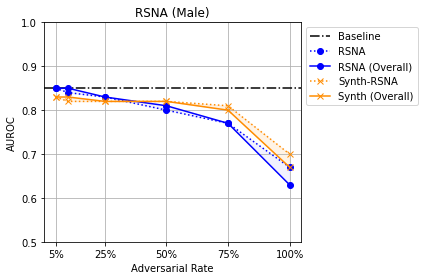

Saved plot for Male at Figures/rsna/auroc_rsna_Male.png
Processing: Female
[0.84, 0.85, 0.85, 0.81, 0.81, 0.76] [0.84, 0.84, 0.85, 0.85, 0.84, 0.79]


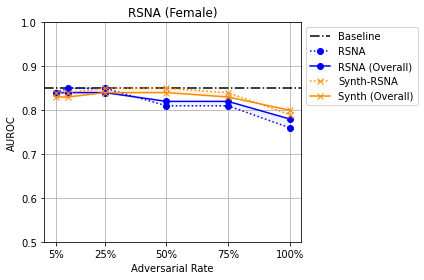

Saved plot for Female at Figures/rsna/auroc_rsna_Female.png
Processing: 0-20 Y
[0.89, 0.89, 0.87, 0.86, 0.85, 0.75] [0.89, 0.87, 0.88, 0.85, 0.84, 0.79]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


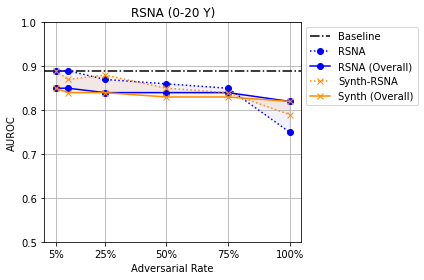

Saved plot for 0-20 Y at Figures/rsna/auroc_rsna_0-20 Y.png
Processing: 20-40 Y
[0.85, 0.84, 0.84, 0.84, 0.84, 0.8] [0.85, 0.85, 0.86, 0.85, 0.84, 0.81]


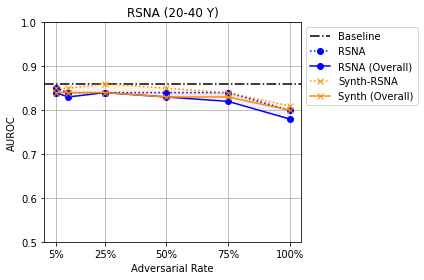

Saved plot for 20-40 Y at Figures/rsna/auroc_rsna_20-40 Y.png
Processing: 40-60 Y
[0.83, 0.84, 0.82, 0.82, 0.82, 0.78] [0.84, 0.84, 0.84, 0.83, 0.84, 0.82]


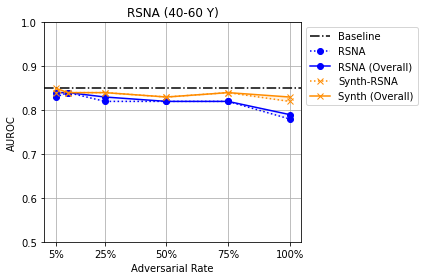

Saved plot for 40-60 Y at Figures/rsna/auroc_rsna_40-60 Y.png
Processing: 60-80 Y
[0.81, 0.81, 0.81, 0.8, 0.8, 0.8] [0.81, 0.81, 0.8, 0.8, 0.8, 0.79]


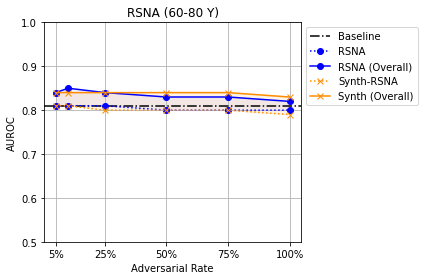

Saved plot for 60-80 Y at Figures/rsna/auroc_rsna_60-80 Y.png
Processing: 80+ Y
[0.83, 0.86, 0.83, 0.82, 0.83, 0.83] [0.84, 0.85, 0.84, 0.84, 0.85, 0.86]


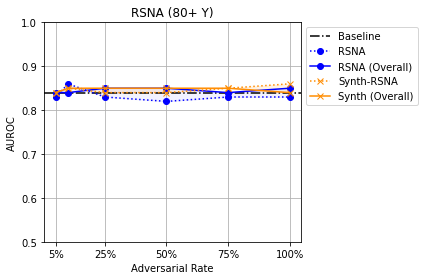

Saved plot for 80+ Y at Figures/rsna/auroc_rsna_80+ Y.png
All plots generated successfully!


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "rsna"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
    "20-40 Y": {"target_sex": None, "target_age": "20-40"},
    "40-60 Y": {"target_sex": None, "target_age": "40-60"},
    "60-80 Y": {"target_sex": None, "target_age": "60-80"},
    "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values, synth_values)

    # Create plot
    plt.figure(figsize=(6, 4))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    plt.plot(rates, rsna_overall, label="RSNA (Overall)", color='blue', marker='o')

    # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth (Overall)", color='darkorange', marker='x')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, rsna_overall, rsna_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('AUROC')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0.50, 1.00)
    plt.title(f"RSNA ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/auroc_{model}_{group}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

In [301]:
import numpy as np

# Given data
rate = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

rsna_data = [
    [0.85, 0.84, 0.83, 0.8, 0.77, 0.67],  # Male
    [0.84, 0.85, 0.85, 0.81, 0.81, 0.76],  # Female
    [0.89, 0.89, 0.87, 0.86, 0.85, 0.75], # 0-20 Y
    [0.85, 0.84, 0.84, 0.84, 0.84, 0.8], # 20-40 Y
    [0.83, 0.84, 0.82, 0.82, 0.82, 0.78], # 40-60 Y
    [0.81, 0.81, 0.81, 0.8, 0.8, 0.8], # 60-80 Y
    [0.83, 0.86, 0.83, 0.82, 0.83, 0.83],  # 80+ Y
]

synth_data = [
    [0.83, 0.82, 0.82, 0.82, 0.81, 0.7],  # Male
    [0.84, 0.84, 0.85, 0.85, 0.84, 0.79],  # Female
    [0.89, 0.87, 0.88, 0.85, 0.84, 0.79],  # 0-20 Y
    [0.85, 0.85, 0.86, 0.85, 0.84, 0.81], # 20-40 Y
    [0.84, 0.84, 0.84, 0.83, 0.84, 0.82],  # 40-60 Y
    [0.81, 0.81, 0.8, 0.8, 0.8, 0.79],  # 60-80 Y
    [0.84, 0.85, 0.84, 0.84, 0.85, 0.86], # 80+ Y
]

# Compute and print mean ± std for each rate
for r in range(len(rate)):
    rsna_vals, synth_vals = [], []
    for i in range(len(rsna_data)):
        rsna_vals.append(rsna_data[i][r])
        synth_vals.append(synth_data[i][r])

    rsna_mean, rsna_std = round(sum(rsna_vals)/len(rsna_vals), 3), round(np.std(rsna_vals), 2)
    synth_mean, synth_std = round(sum(synth_vals)/len(synth_vals), 3), round(np.std(synth_vals), 2)

    print(f"\nRate = {rate[r]}")
    print(f"RSNA: {rsna_mean} ± {rsna_std}")
    print(f"Synth-RSNA: {synth_mean} ± {synth_std}")


Rate = 0.05
RSNA: 0.843 ± 0.02
Synth-RSNA: 0.843 ± 0.02

Rate = 0.1
RSNA: 0.847 ± 0.02
Synth-RSNA: 0.84 ± 0.02

Rate = 0.25
RSNA: 0.836 ± 0.02
Synth-RSNA: 0.841 ± 0.02

Rate = 0.5
RSNA: 0.821 ± 0.02
Synth-RSNA: 0.834 ± 0.02

Rate = 0.75
RSNA: 0.817 ± 0.02
Synth-RSNA: 0.831 ± 0.02

Rate = 1.0
RSNA: 0.77 ± 0.05
Synth-RSNA: 0.794 ± 0.04


## AGESEX vs SEX Plots

Processing: Female
[0.23, 0.22, 0.27, 0.34, 0.37, 0.7]
[0.18, 0.17, 0.22, 0.24, 0.27, 0.69]
[0.21, 0.2, 0.21, 0.25, 0.28, 0.52]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


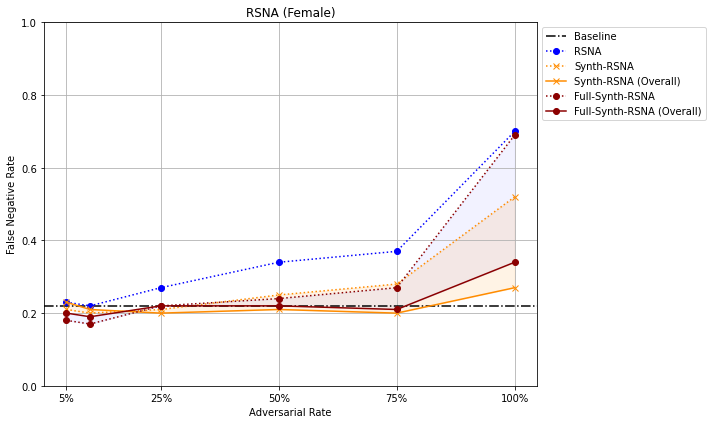

Saved plot for Female at Figures/rsna/rsna_Female_300K.png
Processing: 0-20 Y
[0.11, 0.13, 0.16, 0.21, 0.28, 0.52]
[0.09, 0.11, 0.13, 0.18, 0.25, 0.52]
[0.09, 0.1, 0.11, 0.18, 0.25, 0.38]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


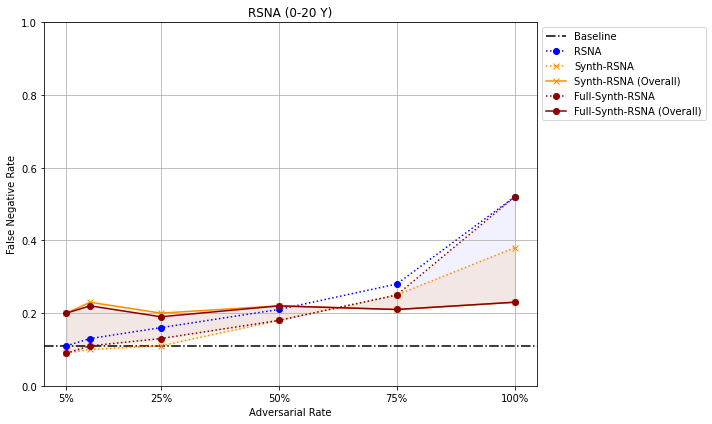

Saved plot for 0-20 Y at Figures/rsna/rsna_0-20 Y_300K.png
All plots generated successfully!


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "rsna"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
#     "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
#     "20-40 Y": {"target_sex": None, "target_age": "20-40"},
#     "40-60 Y": {"target_sex": None, "target_age": "40-60"},
#     "60-80 Y": {"target_sex": None, "target_age": "60-80"},
#     "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    synth_300_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_300_overall, synth_300_values, synth_300_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)
        
    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_300_df, params["target_sex"], params["target_age"], rate)
        synth_300_overall.append(overall)
        synth_300_values.append(fnr)
        synth_300_std.append(std)
        
    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary(AGE).csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values)
    print(synth_300_values)
    print(synth_values)


    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    
    # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth-RSNA (Overall)", color='darkorange', marker='x')
    
     # Plot Synth-RSNA 300k data
    plt.plot(rates, synth_300_values, label="Full-Synth-RSNA", color='darkred', linestyle='dotted', marker='o')
    plt.plot(rates, synth_300_overall, label="Full-Synth-RSNA (Overall)", color='darkred', marker='o')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, synth_300_overall, synth_300_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('False Negative Rate')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0, 1.00)
    plt.title(f"RSNA ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/{model}_{group}_300K.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

## RSNA AUROC

Processing: Female
[0.84, 0.85, 0.85, 0.81, 0.81, 0.76]
[0.86, 0.84, 0.82, 0.83, 0.83, 0.76]
[0.84, 0.84, 0.85, 0.85, 0.84, 0.79]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


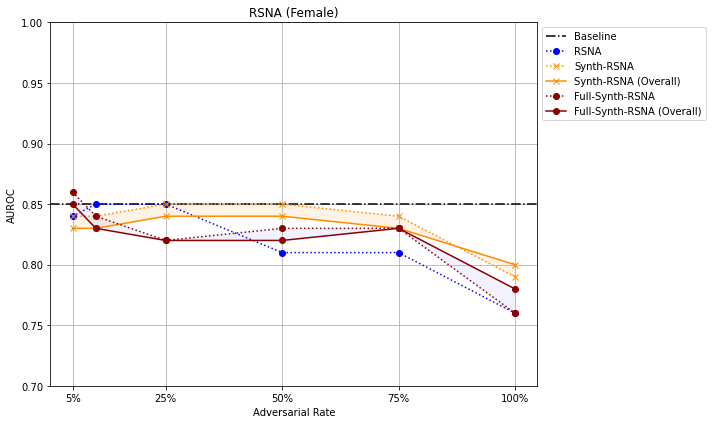

Saved plot for Female at Figures/rsna/AUROC_rsna_Female_300K.png
Processing: 0-20 Y
[0.89, 0.89, 0.87, 0.86, 0.85, 0.75]
[0.88, 0.87, 0.86, 0.86, 0.82, 0.76]
[0.89, 0.87, 0.88, 0.85, 0.84, 0.79]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


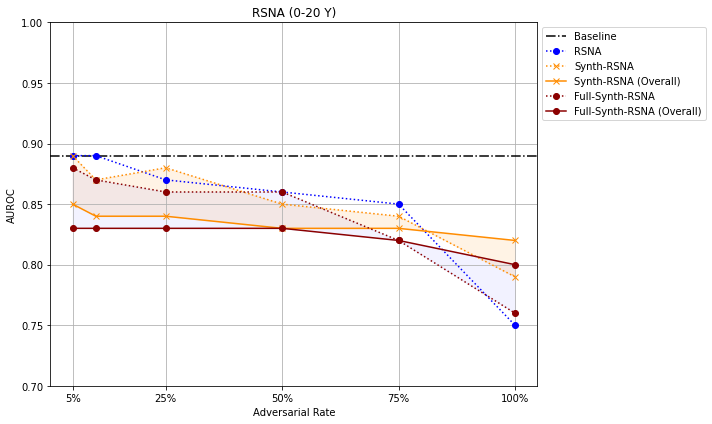

Saved plot for 0-20 Y at Figures/rsna/AUROC_rsna_0-20 Y_300K.png
All plots generated successfully!


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "rsna"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
#     "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
#     "20-40 Y": {"target_sex": None, "target_age": "20-40"},
#     "40-60 Y": {"target_sex": None, "target_age": "40-60"},
#     "60-80 Y": {"target_sex": None, "target_age": "60-80"},
#     "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    synth_300_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_300_overall, synth_300_values, synth_300_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)
        
    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_300_df, params["target_sex"], params["target_age"], rate)
        synth_300_overall.append(overall)
        synth_300_values.append(fnr)
        synth_300_std.append(std)
        
    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary(AGE).csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values)
    print(synth_300_values)
    print(synth_values)


    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    
    # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth-RSNA (Overall)", color='darkorange', marker='x')
    
     # Plot Synth-RSNA 300k data
    plt.plot(rates, synth_300_values, label="Full-Synth-RSNA", color='darkred', linestyle='dotted', marker='o')
    plt.plot(rates, synth_300_overall, label="Full-Synth-RSNA (Overall)", color='darkred', marker='o')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, synth_300_overall, synth_300_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('AUROC')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0.7, 1.00)
    plt.title(f"RSNA ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/AUROC_{model}_{group}_300K.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

# CheXpert 

Processing: Female
[0.4, 0.41, 0.45, 0.52, 0.53, 0.6]
[0.28, 0.28, 0.3, 0.32, 0.33, 0.5]
[0.25, 0.27, 0.29, 0.31, 0.37, 0.56]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


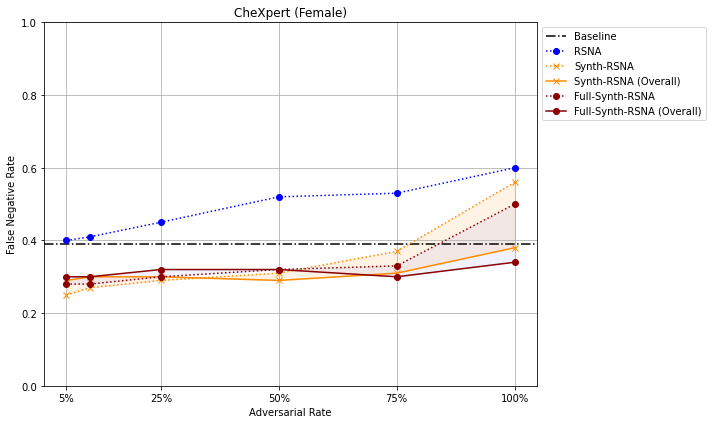

Saved plot for Female at Figures/cxpt/cxpt_Female_300K.png
Processing: 0-20 Y
[0.42, 0.44, 0.44, 0.43, 0.45, 0.46]
[0.42, 0.38, 0.38, 0.39, 0.42, 0.48]
[0.31, 0.34, 0.37, 0.33, 0.4, 0.34]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


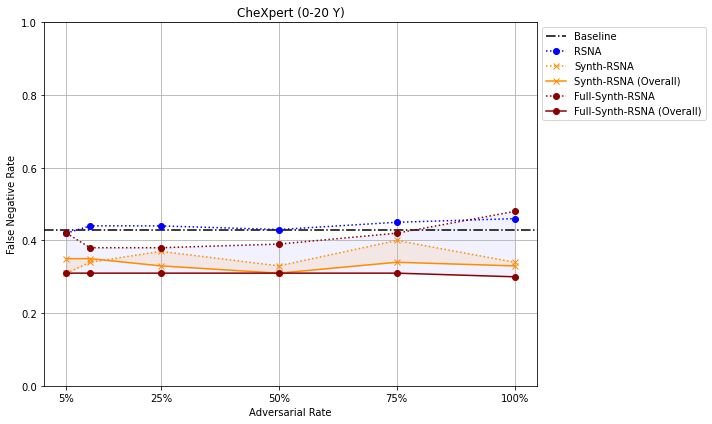

Saved plot for 0-20 Y at Figures/cxpt/cxpt_0-20 Y_300K.png
All plots generated successfully!


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "cxpt"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
#     "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
#     "20-40 Y": {"target_sex": None, "target_age": "20-40"},
#     "40-60 Y": {"target_sex": None, "target_age": "40-60"},
#     "60-80 Y": {"target_sex": None, "target_age": "60-80"},
#     "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    synth_300_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_300_overall, synth_300_values, synth_300_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)
        
    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_300_df, params["target_sex"], params["target_age"], rate)
        synth_300_overall.append(overall)
        synth_300_values.append(fnr)
        synth_300_std.append(std)
        
    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary(AGE).csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values)
    print(synth_300_values)
    print(synth_values)


    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    
 # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth-RSNA (Overall)", color='darkorange', marker='x')
    
     # Plot Synth-RSNA 300k data
    plt.plot(rates, synth_300_values, label="Full-Synth-RSNA", color='darkred', linestyle='dotted', marker='o')
    plt.plot(rates, synth_300_overall, label="Full-Synth-RSNA (Overall)", color='darkred', marker='o')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, synth_300_overall, synth_300_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('False Negative Rate')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0, 1.00)
    plt.title(f"CheXpert ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/{model}_{group}_300K.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

Processing: Female
[0.65, 0.64, 0.64, 0.62, 0.61, 0.64]
[0.68, 0.68, 0.67, 0.67, 0.67, 0.63]
[0.68, 0.68, 0.68, 0.68, 0.66, 0.62]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


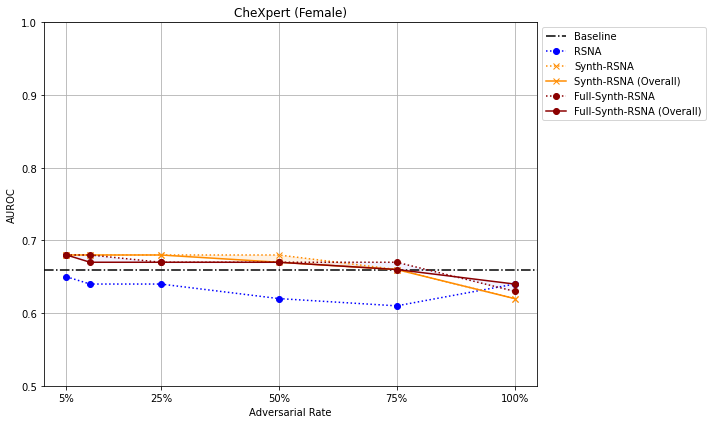

Saved plot for Female at Figures/cxpt/AUROC_cxpt_Female_300K.png
Processing: 0-20 Y
[0.68, 0.7, 0.67, 0.7, 0.69, 0.68]
[0.73, 0.73, 0.73, 0.73, 0.72, 0.72]
[0.69, 0.67, 0.69, 0.69, 0.68, 0.69]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


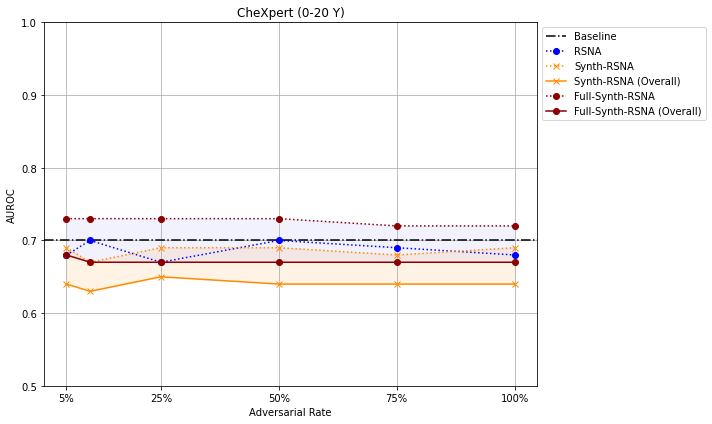

Saved plot for 0-20 Y at Figures/cxpt/AUROC_cxpt_0-20 Y_300K.png
All plots generated successfully!


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "cxpt"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
#     "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
#     "20-40 Y": {"target_sex": None, "target_age": "20-40"},
#     "40-60 Y": {"target_sex": None, "target_age": "40-60"},
#     "60-80 Y": {"target_sex": None, "target_age": "60-80"},
#     "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    synth_300_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_300_overall, synth_300_values, synth_300_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)
        
    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_300_df, params["target_sex"], params["target_age"], rate)
        synth_300_overall.append(overall)
        synth_300_values.append(fnr)
        synth_300_std.append(std)
        
    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary(AGE).csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values)
    print(synth_300_values)
    print(synth_values)


    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    
 # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth-RSNA (Overall)", color='darkorange', marker='x')
    
     # Plot Synth-RSNA 300k data
    plt.plot(rates, synth_300_values, label="Full-Synth-RSNA", color='darkred', linestyle='dotted', marker='o')
    plt.plot(rates, synth_300_overall, label="Full-Synth-RSNA (Overall)", color='darkred', marker='o')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, synth_300_overall, synth_300_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('AUROC')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0.5, 1.00)
    plt.title(f"CheXpert ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/AUROC_{model}_{group}_300K.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

Processing: Female
[0.37, 0.37, 0.43, 0.47, 0.49, 0.47]
[0.29, 0.29, 0.29, 0.32, 0.32, 0.48]
[0.26, 0.28, 0.3, 0.31, 0.36, 0.52]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


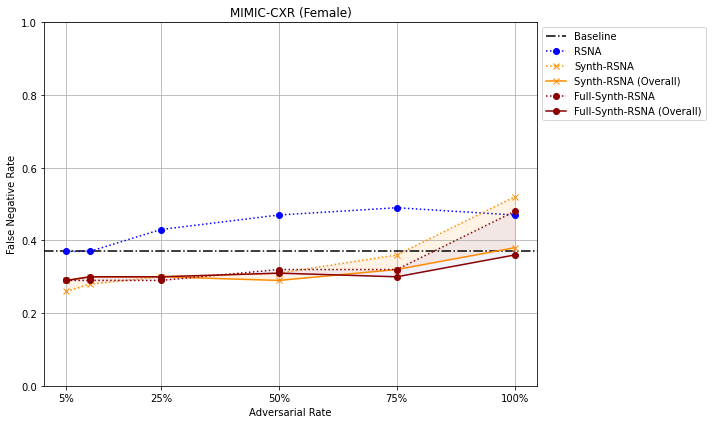

Saved plot for Female at Figures/mimic/mimic_Female_300K.png
Processing: 0-20 Y
[0.49, 0.57, 0.52, 0.53, 0.52, 0.52]
[0.6, 0.58, 0.55, 0.56, 0.59, 0.64]
[0.45, 0.52, 0.52, 0.52, 0.55, 0.52]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


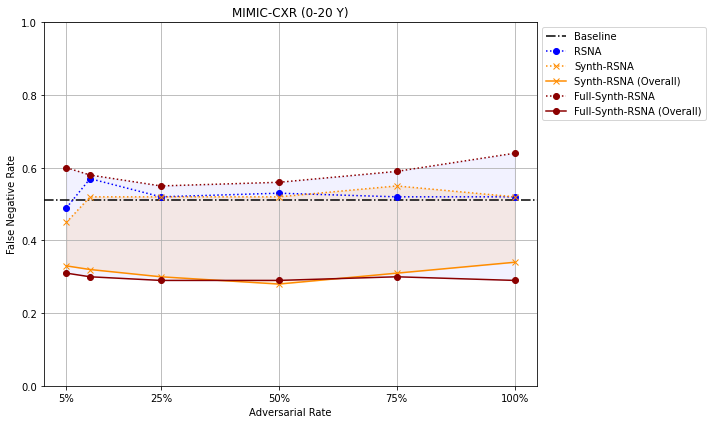

Saved plot for 0-20 Y at Figures/mimic/mimic_0-20 Y_300K.png
All plots generated successfully!


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "mimic"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
#     "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
#     "20-40 Y": {"target_sex": None, "target_age": "20-40"},
#     "40-60 Y": {"target_sex": None, "target_age": "40-60"},
#     "60-80 Y": {"target_sex": None, "target_age": "60-80"},
#     "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    synth_300_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_300_overall, synth_300_values, synth_300_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)
        
    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_300_df, params["target_sex"], params["target_age"], rate)
        synth_300_overall.append(overall)
        synth_300_values.append(fnr)
        synth_300_std.append(std)
        
    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary(AGE).csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values)
    print(synth_300_values)
    print(synth_values)


    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    
 # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth-RSNA (Overall)", color='darkorange', marker='x')
    
     # Plot Synth-RSNA 300k data
    plt.plot(rates, synth_300_values, label="Full-Synth-RSNA", color='darkred', linestyle='dotted', marker='o')
    plt.plot(rates, synth_300_overall, label="Full-Synth-RSNA (Overall)", color='darkred', marker='o')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, synth_300_overall, synth_300_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('False Negative Rate')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0, 1.00)
    plt.title(f"MIMIC-CXR ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/{model}_{group}_300K.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

Processing: Female
[0.68, 0.68, 0.67, 0.64, 0.65, 0.68]
[0.7, 0.7, 0.69, 0.69, 0.69, 0.66]
[0.69, 0.7, 0.7, 0.7, 0.7, 0.67]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


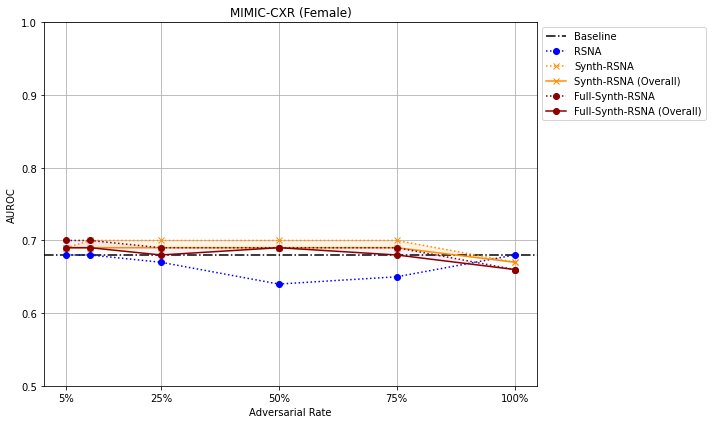

Saved plot for Female at Figures/mimic/AUROC_mimic_Female_300K.png
Processing: 0-20 Y
[0.76, 0.76, 0.75, 0.77, 0.79, 0.77]
[0.75, 0.76, 0.77, 0.77, 0.76, 0.76]
[0.75, 0.72, 0.75, 0.74, 0.72, 0.71]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


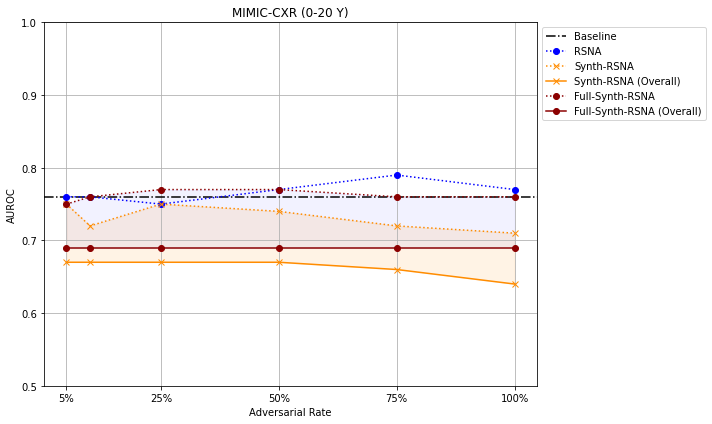

Saved plot for 0-20 Y at Figures/mimic/AUROC_mimic_0-20 Y_300K.png
All plots generated successfully!


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "mimic"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Define demographic groups
groups = {
#     "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
#     "20-40 Y": {"target_sex": None, "target_age": "20-40"},
#     "40-60 Y": {"target_sex": None, "target_age": "40-60"},
#     "60-80 Y": {"target_sex": None, "target_age": "60-80"},
#     "80+ Y": {"target_sex": None, "target_age": "80+"},
}

rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    if target_sex:
        filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'].isna()) & (df['rate'] == rate)]
    elif target_age:
        filtered_df = filtered_df[(filtered_df['target_sex'].isna()) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

# Process each group and generate plots
for group, params in groups.items():
    print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"{model}_summary.csv")
    rsna_overall, rsna_values, rsna_std = [], [], []
    
    # Read RSNA dataset
    synth_300_df = pd.read_csv(f"augmented_{model}_summary.csv")
    synth_300_overall, synth_300_values, synth_300_std = [], [], []
    
    # Read RSNA dataset
    base_df = pd.read_csv(f"baseline_{model}_summary.csv")
    base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)

    for rate in rates:
        overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
        rsna_overall.append(overall)
        rsna_values.append(fnr)
        rsna_std.append(std)
        
    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_300_df, params["target_sex"], params["target_age"], rate)
        synth_300_overall.append(overall)
        synth_300_values.append(fnr)
        synth_300_std.append(std)
        
    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_{model}_summary(AGE).csv")
    synth_overall, synth_values, synth_std = [], [], []

    for rate in rates:
        overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
        synth_overall.append(overall)
        synth_values.append(fnr)
        synth_std.append(std)
        
    print(rsna_values)
    print(synth_300_values)
    print(synth_values)


    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='dashdot', label="Baseline")

    # Plot RSNA data
    plt.plot(rates, rsna_values, label="RSNA", color='blue', linestyle='dotted', marker='o')
    
 # Plot Synth-RSNA data
    plt.plot(rates, synth_values, label="Synth-RSNA", color='darkorange', linestyle='dotted', marker='x')
    plt.plot(rates, synth_overall, label="Synth-RSNA (Overall)", color='darkorange', marker='x')
    
     # Plot Synth-RSNA 300k data
    plt.plot(rates, synth_300_values, label="Full-Synth-RSNA", color='darkred', linestyle='dotted', marker='o')
    plt.plot(rates, synth_300_overall, label="Full-Synth-RSNA (Overall)", color='darkred', marker='o')

    # Fill areas between overall and subgroup
    plt.fill_between(rates, synth_300_overall, synth_300_values, color='blue', alpha=0.05)
    plt.fill_between(rates, synth_overall, synth_values, color='darkorange', alpha=0.1)

    # Labels and title
    plt.ylabel('AUROC')
    plt.xlabel('Adversarial Rate')
    plt.ylim(0.5, 1.00)
    plt.title(f"MIMIC-CXR ({group})")

    # Custom x-axis labels
    plt.xticks([0.05, 0.25, 0.5, 0.75, 1.00], ['5%', '25%', '50%', '75%', '100%'])

    # Move legend outside
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.grid()

    # Save figure
    save_path = os.path.join(output_dir, f"{model}/AUROC_{model}_{group}_300K.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Saved plot for {group} at {save_path}")

print("All plots generated successfully!")

# Random experiments results

In [23]:
import os 
import json

# Define demographic groups
files = [f"../../src/{f}" for f in os.listdir('../../src') if ".json" in f]
groups = {}
group_rates = {}

for i in range(len(files)):
    with open(files[i]) as json_file:
        data = json.load(json_file)
    groups[i] = {"target_sex": data['dem_sex'], "target_age": data['dem_age']}
    group_rates[i] = f"{data['rate_sex']}&{data['rate_age']}"
groups

{0: {'target_sex': 'F', 'target_age': '0-20'},
 1: {'target_sex': 'F', 'target_age': '80+'},
 2: {'target_sex': 'F', 'target_age': '80+'},
 3: {'target_sex': 'M', 'target_age': '80+'},
 4: {'target_sex': 'F', 'target_age': '0-20'},
 5: {'target_sex': 'M', 'target_age': '20-40'},
 6: {'target_sex': 'M', 'target_age': '0-20'},
 7: {'target_sex': 'F', 'target_age': '60-80'},
 8: {'target_sex': 'M', 'target_age': '0-20'},
 9: {'target_sex': 'M', 'target_age': '80+'},
 10: {'target_sex': 'M', 'target_age': '40-60'}}

In [91]:
group_rates

{0: '0.76&0.04',
 1: '0.97&0.48',
 2: '0.29&0.72',
 3: '0.89&0.09',
 4: '0.15&0.73',
 5: '0.93&0.51',
 6: '0.67&0.2',
 7: '0.47&0.96',
 8: '0.76&0.34',
 9: '0.19&0.77',
 10: '0.52&0.92'}

In [23]:
del groups[5]
del group_rates[5]

/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


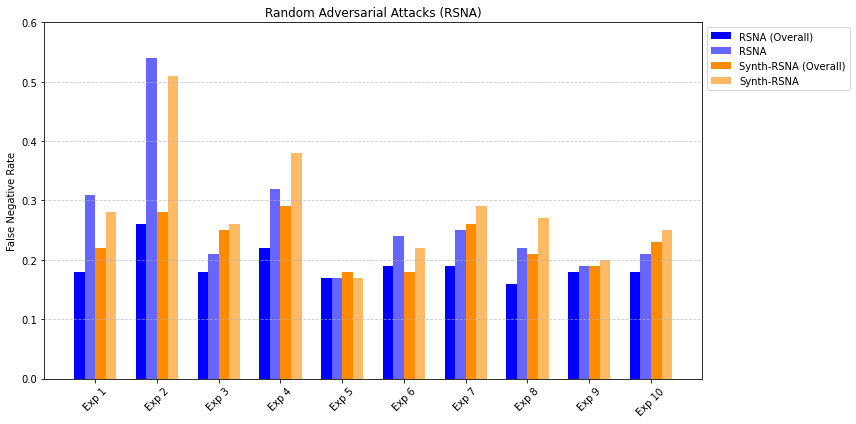

Saved plot for 10 at Figures/rsna/FNR_random_attacks.png


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "rsna"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]

    
    filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)

    return overall_fnr_avg, dem_fnr_avg, std_dev

rsna_overall, rsna_values, rsna_std = [], [], []
synth_overall, synth_values, synth_std = [], [], []
# Process each group and generate plots
for group, params in groups.items():
    # Read RSNA dataset
    rsna_df = pd.read_csv(f"random_{model}_summary.csv")
    
    
#     # Read RSNA dataset
#     base_df = pd.read_csv(f"baseline_{model}_summary.csv")
#     base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
    rsna_overall.append(overall)
    rsna_values.append(fnr)
    rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_random_{model}_summary.csv")
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
    synth_overall.append(overall)
    synth_values.append(fnr)
    synth_std.append(std)
        

        
# Sample Data (Replace with actual values from your script)
experiments = [f'Exp {i+1}' for i in range(len(rsna_values))]
n_experiments = len(experiments)
x = np.arange(n_experiments) * 3.5  # Add spacing between experiments
width = 0.6  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot RSNA
bars1 = ax.bar(x - width * 1.5, rsna_overall, width, label='RSNA (Overall)', color='blue', capsize=5)
bars2 = ax.bar(x - width * 0.5, rsna_values, width, label='RSNA', color='blue', alpha=0.6, capsize=5)

# Plot Synth-RSNA (Ensuring space between experiments)
bars3 = ax.bar(x + width * 0.5, synth_overall, width, label='Synth-RSNA (Overall)', color='darkorange', capsize=5)
bars4 = ax.bar(x + width * 1.5, synth_values, width, label='Synth-RSNA', color='darkorange', alpha=0.6, capsize=5)

# Formatting
ax.set_ylabel("False Negative Rate")
plt.ylim(0, 0.60)
ax.set_title(f"Random Adversarial Attacks ({model.upper()})")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45)
# Move legend outside
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure
save_path = os.path.join(output_dir, f"{model}/FNR_random_attacks.png")
plt.savefig(save_path)
plt.show()

print(f"Saved plot for {group} at {save_path}")


## AUROC graph

/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[0.86, 0.81, 0.88, 0.8, 0.88, 0.85, 0.86, 0.84, 0.87, 0.84] [0.81, 0.8, 0.82, 0.79, 0.84, 0.81, 0.81, 0.8, 0.83, 0.81]


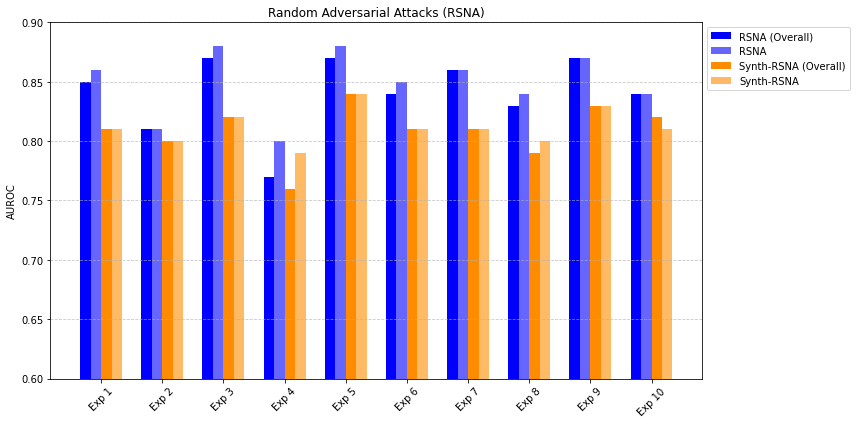

Saved plot for 10 at Figures/rsna/AUROC_random_attacks.png


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "rsna"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

rsna_overall, rsna_values, rsna_std = [], [], []
synth_overall, synth_values, synth_std = [], [], []
# Process each group and generate plots
for group, params in groups.items():
    # Read RSNA dataset
    rsna_df = pd.read_csv(f"random_{model}_summary.csv")
    
    
#     # Read RSNA dataset
#     base_df = pd.read_csv(f"baseline_{model}_summary.csv")
#     base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
    rsna_overall.append(overall)
    rsna_values.append(fnr)
    rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_random_{model}_summary.csv")
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
    synth_overall.append(overall)
    synth_values.append(fnr)
    synth_std.append(std)
        
print(rsna_values, synth_values)
        
# Sample Data (Replace with actual values from your script)
experiments = [f'Exp {i+1}' for i in range(len(rsna_values))]
n_experiments = len(experiments)
x = np.arange(n_experiments) * 3.5  # Add spacing between experiments
width = 0.6  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot RSNA
bars1 = ax.bar(x - width * 1.5, rsna_overall, width, label='RSNA (Overall)', color='blue', capsize=5)
bars2 = ax.bar(x - width * 0.5, rsna_values, width, label='RSNA', color='blue', alpha=0.6, capsize=5)

# Plot Synth-RSNA (Ensuring space between experiments)
bars3 = ax.bar(x + width * 0.5, synth_overall, width, label='Synth-RSNA (Overall)', color='darkorange', capsize=5)
bars4 = ax.bar(x + width * 1.5, synth_values, width, label='Synth-RSNA', color='darkorange', alpha=0.6, capsize=5)

# Formatting
ax.set_ylabel("AUROC")
plt.ylim(0.60, 0.90)
ax.set_title(f"Random Adversarial Attacks ({model.upper()})")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45)
# Move legend outside
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure
save_path = os.path.join(output_dir, f"{model}/AUROC_random_attacks.png")
plt.savefig(save_path)
plt.show()

print(f"Saved plot for {group} at {save_path}")

# Random experiments CheXpert

/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


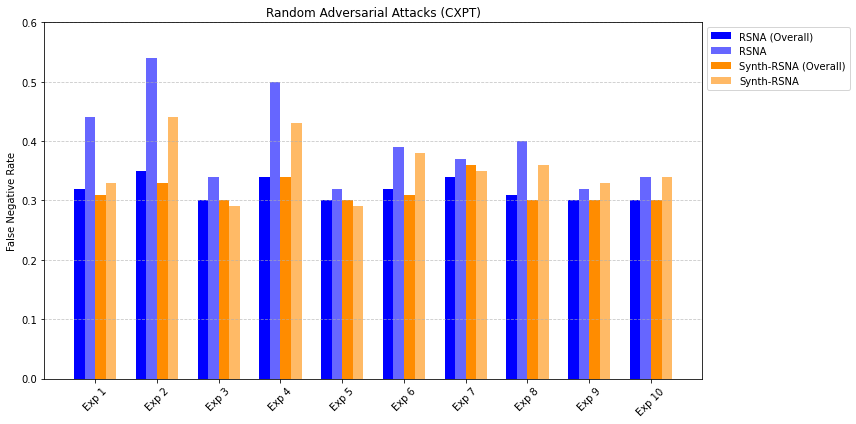

Saved plot for 10 at Figures/cxpt/FNR_random_attacks.png


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "cxpt"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]

    
    filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)

    return overall_fnr_avg, dem_fnr_avg, std_dev

rsna_overall, rsna_values, rsna_std = [], [], []
synth_overall, synth_values, synth_std = [], [], []
# Process each group and generate plots
for group, params in groups.items():
    # Read RSNA dataset
    rsna_df = pd.read_csv(f"random_{model}_summary.csv")
    
    
#     # Read RSNA dataset
#     base_df = pd.read_csv(f"baseline_{model}_summary.csv")
#     base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
    rsna_overall.append(overall)
    rsna_values.append(fnr)
    rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_random_{model}_summary.csv")
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
    synth_overall.append(overall)
    synth_values.append(fnr)
    synth_std.append(std)
        

        
# Sample Data (Replace with actual values from your script)
experiments = [f'Exp {i+1}' for i in range(len(rsna_values))]
n_experiments = len(experiments)
x = np.arange(n_experiments) * 3.5  # Add spacing between experiments
width = 0.6  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot RSNA
bars1 = ax.bar(x - width * 1.5, rsna_overall, width, label='RSNA (Overall)', color='blue', capsize=5)
bars2 = ax.bar(x - width * 0.5, rsna_values, width, label='RSNA', color='blue', alpha=0.6, capsize=5)

# Plot Synth-RSNA (Ensuring space between experiments)
bars3 = ax.bar(x + width * 0.5, synth_overall, width, label='Synth-RSNA (Overall)', color='darkorange', capsize=5)
bars4 = ax.bar(x + width * 1.5, synth_values, width, label='Synth-RSNA', color='darkorange', alpha=0.6, capsize=5)

# Formatting
ax.set_ylabel("False Negative Rate")
plt.ylim(0, 0.60)
ax.set_title(f"Random Adversarial Attacks ({model.upper()})")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45)
# Move legend outside
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure
save_path = os.path.join(output_dir, f"{model}/FNR_random_attacks.png")
plt.savefig(save_path)
plt.show()

print(f"Saved plot for {group} at {save_path}")

[0.67, 0.65, 0.69, 0.65, 0.68, 0.67, 0.66, 0.67, 0.68, 0.67] [0.67, 0.65, 0.68, 0.66, 0.68, 0.67, 0.65, 0.67, 0.68, 0.67]


/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


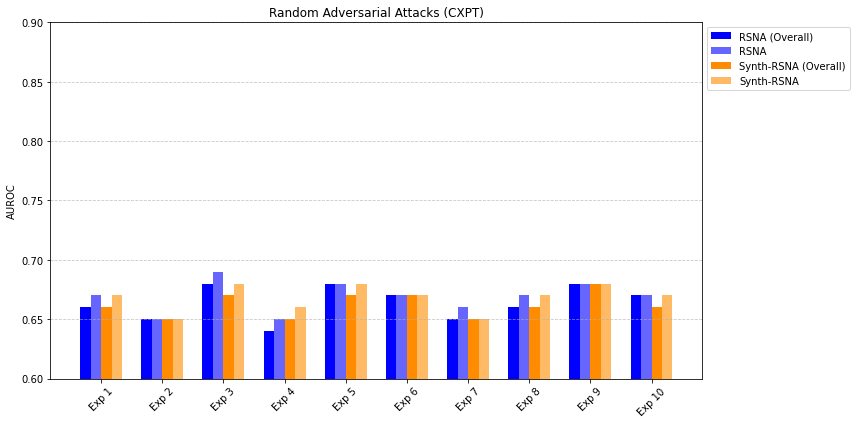

Saved plot for 10 at Figures/cxpt/AUROC_random_attacks.png


In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "cxpt"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

rsna_overall, rsna_values, rsna_std = [], [], []
synth_overall, synth_values, synth_std = [], [], []
# Process each group and generate plots
for group, params in groups.items():
    # Read RSNA dataset
    rsna_df = pd.read_csv(f"random_{model}_summary.csv")
    
    
#     # Read RSNA dataset
#     base_df = pd.read_csv(f"baseline_{model}_summary.csv")
#     base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
    rsna_overall.append(overall)
    rsna_values.append(fnr)
    rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_random_{model}_summary.csv")
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
    synth_overall.append(overall)
    synth_values.append(fnr)
    synth_std.append(std)
        
print(rsna_values, synth_values)
        
# Sample Data (Replace with actual values from your script)
experiments = [f'Exp {i+1}' for i in range(len(rsna_values))]
n_experiments = len(experiments)
x = np.arange(n_experiments) * 3.5  # Add spacing between experiments
width = 0.6  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot RSNA
bars1 = ax.bar(x - width * 1.5, rsna_overall, width, label='RSNA (Overall)', color='blue', capsize=5)
bars2 = ax.bar(x - width * 0.5, rsna_values, width, label='RSNA', color='blue', alpha=0.6, capsize=5)

# Plot Synth-RSNA (Ensuring space between experiments)
bars3 = ax.bar(x + width * 0.5, synth_overall, width, label='Synth-RSNA (Overall)', color='darkorange', capsize=5)
bars4 = ax.bar(x + width * 1.5, synth_values, width, label='Synth-RSNA', color='darkorange', alpha=0.6, capsize=5)

# Formatting
ax.set_ylabel("AUROC")
plt.ylim(0.60, 0.90)
ax.set_title(f"Random Adversarial Attacks ({model.upper()})")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45)
# Move legend outside
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure
save_path = os.path.join(output_dir, f"{model}/AUROC_random_attacks.png")
plt.savefig(save_path)
plt.show()

print(f"Saved plot for {group} at {save_path}")

# Random experiments MIMIC-CXR

/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


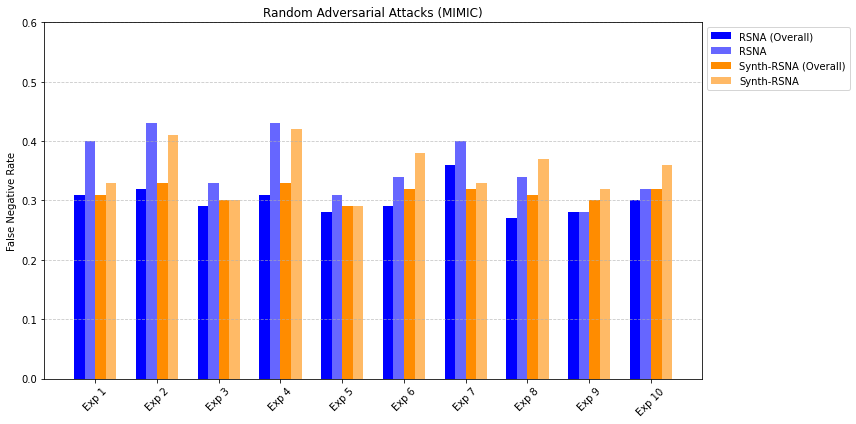

Saved plot for 10 at Figures/mimic/FNR_random_attacks.png


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "mimic"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# rates = [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]

    
    filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)

    return overall_fnr_avg, dem_fnr_avg, std_dev

rsna_overall, rsna_values, rsna_std = [], [], []
synth_overall, synth_values, synth_std = [], [], []
# Process each group and generate plots
for group, params in groups.items():
    # Read RSNA dataset
    rsna_df = pd.read_csv(f"random_{model}_summary.csv")
    
    
#     # Read RSNA dataset
#     base_df = pd.read_csv(f"baseline_{model}_summary.csv")
#     base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
    rsna_overall.append(overall)
    rsna_values.append(fnr)
    rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_random_{model}_summary.csv")
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
    synth_overall.append(overall)
    synth_values.append(fnr)
    synth_std.append(std)
        

        
# Sample Data (Replace with actual values from your script)
experiments = [f'Exp {i+1}' for i in range(len(rsna_values))]
n_experiments = len(experiments)
x = np.arange(n_experiments) * 3.5  # Add spacing between experiments
width = 0.6  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot RSNA
bars1 = ax.bar(x - width * 1.5, rsna_overall, width, label='RSNA (Overall)', color='blue', capsize=5)
bars2 = ax.bar(x - width * 0.5, rsna_values, width, label='RSNA', color='blue', alpha=0.6, capsize=5)

# Plot Synth-RSNA (Ensuring space between experiments)
bars3 = ax.bar(x + width * 0.5, synth_overall, width, label='Synth-RSNA (Overall)', color='darkorange', capsize=5)
bars4 = ax.bar(x + width * 1.5, synth_values, width, label='Synth-RSNA', color='darkorange', alpha=0.6, capsize=5)

# Formatting
ax.set_ylabel("False Negative Rate")
plt.ylim(0, 0.60)
ax.set_title(f"Random Adversarial Attacks ({model.upper()})")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45)
# Move legend outside
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure
save_path = os.path.join(output_dir, f"{model}/FNR_random_attacks.png")
plt.savefig(save_path)
plt.show()

print(f"Saved plot for {group} at {save_path}")

/apps/local/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[0.71, 0.7, 0.72, 0.66, 0.72, 0.69, 0.69, 0.68, 0.71, 0.69] [0.69, 0.68, 0.7, 0.65, 0.7, 0.67, 0.68, 0.67, 0.68, 0.66]


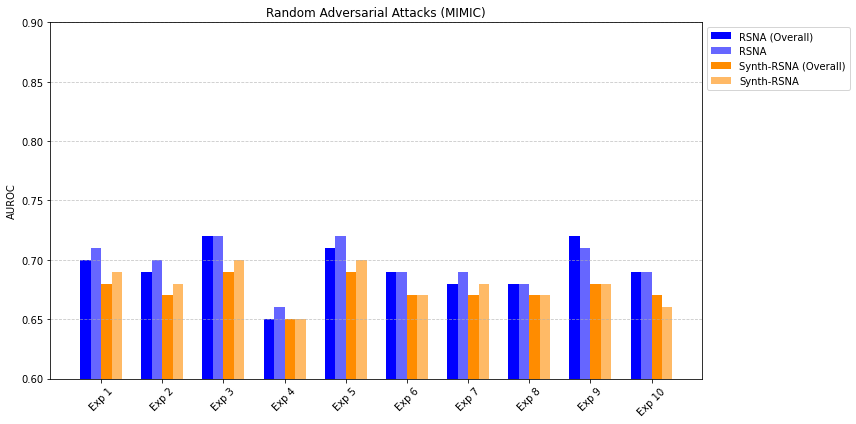

Saved plot for 10 at Figures/mimic/AUROC_random_attacks.png


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
model = "mimic"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

def get_average_fnr(df, target_sex, target_age, rate):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df[(df['rate'] == rate)]
    
    filtered_df = filtered_df[(filtered_df['target_sex'] == target_sex) & (filtered_df['target_age'] == target_age) & (df['rate'] == rate)]
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['auroc']
        dem_fnr_vals.append(dem_subset.iloc[i]['auroc'])
        overall_fnr_sum += baseline.iloc[i]['auroc']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    
    return overall_fnr_avg, dem_fnr_avg, std_dev

rsna_overall, rsna_values, rsna_std = [], [], []
synth_overall, synth_values, synth_std = [], [], []
# Process each group and generate plots
for group, params in groups.items():
    # Read RSNA dataset
    rsna_df = pd.read_csv(f"random_{model}_summary.csv")
    
    
#     # Read RSNA dataset
#     base_df = pd.read_csv(f"baseline_{model}_summary.csv")
#     base_overall, baseline, std = get_average_fnr(base_df, params["target_sex"], params["target_age"], 0)
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(rsna_df, params["target_sex"], params["target_age"], rate)
    rsna_overall.append(overall)
    rsna_values.append(fnr)
    rsna_std.append(std)

    # Read Synth-RSNA dataset
    synth_df = pd.read_csv(f"augmented_random_{model}_summary.csv")
    rate = group_rates[group]
    overall, fnr, std = get_average_fnr(synth_df, params["target_sex"], params["target_age"], rate)
    synth_overall.append(overall)
    synth_values.append(fnr)
    synth_std.append(std)
        
print(rsna_values, synth_values)
        
# Sample Data (Replace with actual values from your script)
experiments = [f'Exp {i+1}' for i in range(len(rsna_values))]
n_experiments = len(experiments)
x = np.arange(n_experiments) * 3.5  # Add spacing between experiments
width = 0.6  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot RSNA
bars1 = ax.bar(x - width * 1.5, rsna_overall, width, label='RSNA (Overall)', color='blue', capsize=5)
bars2 = ax.bar(x - width * 0.5, rsna_values, width, label='RSNA', color='blue', alpha=0.6, capsize=5)

# Plot Synth-RSNA (Ensuring space between experiments)
bars3 = ax.bar(x + width * 0.5, synth_overall, width, label='Synth-RSNA (Overall)', color='darkorange', capsize=5)
bars4 = ax.bar(x + width * 1.5, synth_values, width, label='Synth-RSNA', color='darkorange', alpha=0.6, capsize=5)

# Formatting
ax.set_ylabel("AUROC")
plt.ylim(0.60, 0.90)
ax.set_title(f"Random Adversarial Attacks ({model.upper()})")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45)
# Move legend outside
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure
save_path = os.path.join(output_dir, f"{model}/AUROC_random_attacks.png")
plt.savefig(save_path)
plt.show()

print(f"Saved plot for {group} at {save_path}")

In [159]:
# Define demographic groups
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "40-60": {"target_sex": None, "target_age": "40-60"},
    "Male&40-60": {"target_sex": "M", "target_age": "40-60"},
#     "Female": {"target_sex": "F", "target_age": None},
#     "0-20 Y": {"target_sex": None, "target_age": "0-20"},
#     "20-40 Y": {"target_sex": None, "target_age": "20-40"},
#     "40-60 Y": {"target_sex": None, "target_age": "40-60"},
#     "60-80 Y": {"target_sex": None, "target_age": "60-80"},
#     "80+ Y": {"target_sex": None, "target_age": "80+"},
}

def get_average_fnr(df, target_sex, target_age):
    """Computes the average FNR for a given demographic group and adversarial rate."""
    filtered_df = df
    
    # Extract baseline (Overall FNR)
    baseline = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'].isna())]
    if target_sex is not None and target_age is not None:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age']==target_age)]
    if target_sex:
        dem_subset = filtered_df[(filtered_df['dem_sex'] == target_sex) & (filtered_df['dem_age'].isna())]
    elif target_age:
        dem_subset = filtered_df[(filtered_df['dem_sex'].isna()) & (filtered_df['dem_age'] == target_age)]
        
    num_trials = 5
    dem_fnr_sum, overall_fnr_sum = 0, 0
    dem_fnr_vals = []
    overall_vals = []
    
    for i in range(num_trials):
        dem_fnr_sum += dem_subset.iloc[i]['fnr']
        dem_fnr_vals.append(dem_subset.iloc[i]['fnr'])
        overall_vals.append(baseline.iloc[i]['fnr'])
        overall_fnr_sum += baseline.iloc[i]['fnr']
    
    dem_fnr_avg = round(dem_fnr_sum / num_trials, 2)
    overall_fnr_avg = round(overall_fnr_sum / num_trials, 2)
    std_dev = round(np.std(dem_fnr_vals), 2)
    overall_std_dev = round(np.std(overall_vals), 2)

    return overall_fnr_avg, dem_fnr_avg, std_dev, overall_std_dev


In [233]:
group_ids = ["M", "F", "0-20", "20-40", "40-60", "60-80", "80+"]
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
    "20-40 Y": {"target_sex": None, "target_age": "20-40"},
    "40-60 Y": {"target_sex": None, "target_age": "40-60"},
    "60-80 Y": {"target_sex": None, "target_age": "60-80"},
    "80+ Y": {"target_sex": None, "target_age": "80+"},
}

# Process each group and generate plots
rsna_overall, rsna_values, rsna_std, overall_std = [], [], [], []
final_results = {}
i = 0
for group, params in groups.items():
#     print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"augmented_random_{model}_summary.csv")

    overall, fnr, std, std_base = get_average_fnr(rsna_df, params["target_sex"], params["target_age"])
    rsna_overall.append(overall)
    rsna_values.append(fnr)
    rsna_std.append(std)
    overall_std.append(std_base)
    
    final_results[group_ids[i]] = fnr
    i+=1
final_results["Overall"] = round(sum(rsna_overall) / len(rsna_overall), 2)

# get final_results
results = final_results

# Extract the overall value
overall_value = 0.23#results['Overall']

# Compute differences from overall
values = []
for k, v in results.items():
    if k != 'Overall':
        values.append(round(abs(v - overall_value), 2))
print(values)
# Compute mean and standard deviation
mean_diff = round(sum(values)/len(values), 2)
std_diff = round(np.std(values), 2)

# Print results neatly
print(f"Mean Difference: {mean_diff}")
print(f"Standard Deviation: {std_diff}")

[0.02, 0.04, 0.13, 0.03, 0.02, 0.08, 0.03]
Mean Difference: 0.05
Standard Deviation: 0.04


In [234]:
group_ids = ["M", "F", "0-20", "20-40", "40-60", "60-80", "80+"]
groups = {
    "Male": {"target_sex": "M", "target_age": None},
    "Female": {"target_sex": "F", "target_age": None},
    "0-20 Y": {"target_sex": None, "target_age": "0-20"},
    "20-40 Y": {"target_sex": None, "target_age": "20-40"},
    "40-60 Y": {"target_sex": None, "target_age": "40-60"},
    "60-80 Y": {"target_sex": None, "target_age": "60-80"},
    "80+ Y": {"target_sex": None, "target_age": "80+"},
}

# Process each group and generate plots
rsna_overall, rsna_values, rsna_std, overall_std = [], [], [], []
final_results = {}
i = 0
for group, params in groups.items():
#     print(f"Processing: {group}")

    # Read RSNA dataset
    rsna_df = pd.read_csv(f"random_{model}_summary.csv")

    overall, fnr, std, std_base = get_average_fnr(rsna_df, params["target_sex"], params["target_age"])
    rsna_overall.append(overall)
    rsna_values.append(fnr)
    rsna_std.append(std)
    overall_std.append(std_base)
    
    final_results[group_ids[i]] = fnr
    i+=1
final_results["Overall"] = round(sum(rsna_overall) / len(rsna_overall), 2)
print(final_result)
# get final_results
results = final_results

# Extract the overall value
overall_value = 0.23#results['Overall']

# Compute differences from overall
values = []
for k, v in results.items():
    if k != 'Overall':
        values.append(round(abs(v - overall_value), 2))
print(values)
# Compute mean and standard deviation
mean_diff = round(sum(values)/len(values), 2)
std_diff = round(np.std(values), 2)

# Print results neatly
print(f"Mean Difference: {mean_diff}")
print(f"Standard Deviation: {std_diff}")

[0.02, 0.09, 0.18, 0.07, 0.01, 0.0, 0.05]
Mean Difference: 0.06
Standard Deviation: 0.06


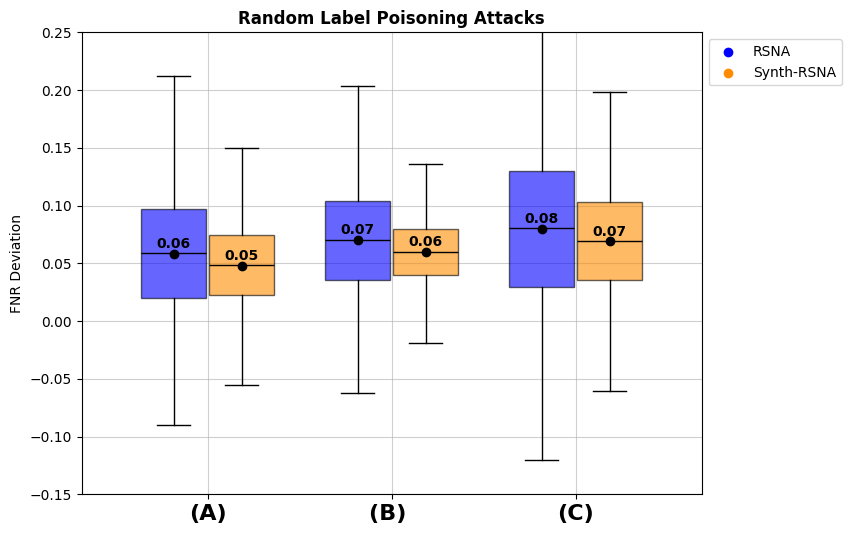

In [281]:
# Ensure output directory exists
model = "rsna"
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# Box plot data for multiple experiments
experiments = [
    (0.06, 0.06, 0.05, 0.04),  # Experiment 1
    (0.07, 0.05, 0.06, 0.03),  # Experiment 2
    (0.08, 0.07, 0.07, 0.05)   # Experiment 3
]

data = []
colors = ['blue', 'darkorange'] * len(experiments)
positions = []
#x_labels = [f'Experiment {i+1}' for i in range(len(experiments))]
x_labels = ['(A)', '(B) ', '(C)']
spacing = 0.185  # Adjust this value to make the boxes touch
means = []

for i, (rsna_mean, rsna_std, synth_mean, synth_std) in enumerate(experiments):
    rsna_data = np.random.normal(rsna_mean, rsna_std, 1000)
    synth_data = np.random.normal(synth_mean, synth_std, 1000)
    
    data.append(rsna_data)
    data.append(synth_data)
    
    positions.extend([i + 1 - spacing, i + 1 + spacing])
    means.extend([(i + 1 - spacing, np.mean(rsna_data)), (i + 1 + spacing, np.mean(synth_data))])

# Create box plot
plt.figure(figsize=(8, 6))
bp = plt.boxplot(data, positions=positions, patch_artist=True, 
                 boxprops=dict(alpha=0.6),
                 medianprops=dict(color='black'), showfliers=False, showmeans=True,
                 meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=6))

# Apply colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Annotate mean values
for pos, mean_val in means:
    plt.text(pos, mean_val + 0.005, f"{mean_val:.2f}", ha='center', fontsize=10, fontweight='bold')

# Add legend
plt.scatter([], [], color='blue', label='RSNA')  
plt.scatter([], [], color='darkorange', label='Synth-RSNA')
# Move legend outside
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylim(-0.15, 0.25)
plt.xticks(range(1, len(x_labels) + 1), x_labels, fontsize=16, fontweight='bold')
plt.ylabel("FNR Deviation")
plt.title("Random Label Poisoning Attacks", fontsize=12, fontweight='bold')
plt.grid(True, linestyle="-", alpha=0.6)

# Save figure
save_path = os.path.join(output_dir, f"{model}/box_{model}_{group}.png")
plt.savefig(save_path, bbox_inches='tight')

In [287]:
# Mean FNR (rate = 1.00)
print("\nrate = 1.00")
rsna = [0.82, 0.7, 0.52, 0.33, 0.28, 0.44, 0.28]
synth = [0.63, 0.52, 0.38, 0.27, 0.25, 0.37, 0.17]

rsna_mean, rsna_std = round(sum(rsna)/len(rsna), 2), round(np.std(rsna),2)
synth_mean, synth_std = round(sum(synth)/len(synth), 2), round(np.std(synth),2)
print(rsna_mean, " +/- ", rsna_std)
print(synth_mean, " +/- ", synth_std)

# Mean FNR (rate = 0.75)
rsna = [0.82, 0.7, 0.52, 0.33, 0.28, 0.44, 0.28]
synth = [0.63, 0.52, 0.38, 0.27, 0.25, 0.37, 0.17]

rsna_mean, rsna_std = round(sum(rsna)/len(rsna), 2), round(np.std(rsna),2)
synth_mean, synth_std = round(sum(synth)/len(synth), 2), round(np.std(synth),2)
print("\nrate = 0.75")
print(rsna_mean, " +/- ", rsna_std)
print(synth_mean, " +/- ", synth_std)


# Mean FNR (rate = 0.50)
# Mean FNR (rate = 0.25)
# Mean FNR (rate = 0.10)
# Mean FNR (rate = 0.10)



rate = 1.00
0.48  +/-  0.2
0.37  +/-  0.15

rate = 0.75
0.48  +/-  0.2
0.37  +/-  0.15


# Evaluating individual models 

In [2]:
import os
import pandas as pd

In [6]:
rsna_csv = 'augmented_rsna_summary.csv'
df = pd.DataFrame(pd.read_csv(rsna_csv))
df = df[(df['target_sex']=="M") & (df['target_age'] == '40-60') & (df['rate'] == -1) & (df['trial'] == 0)] # performance on females with no labels changed
df

,target_sex,target_age,trial,rate,dem_sex,dem_age,auroc,tpr,fnr,tnr,fpr,ppv,npv,fomr,tn,fp,fn,tp


In [23]:
list(df[df["trial"] == 0]['fnr'])[0]

0.244195356285028

## Target Age == '80+'

In [3]:
# Overall
baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
dem0_20 = df[(df['dem_age'] == '80+') & (df['dem_sex'].isna())]

print("overall FNR: ", baseline.iloc[0]['fnr'])
print("0.05 FNR: ",dem0_20.iloc[0]['fnr'])

NameError: name 'df' is not defined

In [28]:
# evaluate random rsna
import numpy as np

target_age = '40-60'
target_sex = "M"
# Get Synth_RSNA summary
def get_average_fnr(rate=0.5):
    rsna_csv = 'random_rsna_summary.csv'
    df = pd.DataFrame(pd.read_csv(rsna_csv))
    df = df[(df['target_sex'] == "M") & (df['target_age'] == target) & (df['rate'] == rate)] # performance on females with no labels changed

    # Overall
    baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
    age = df[(df['dem_sex'].isna()) & (df['dem_age'] == target_age)]
    sex = df[(df['dem_sex'] == target_sex) & (df['dem_age'].isna())]
    sexage = df[(df['dem_sex'] == target_sex) & (df['dem_age'] == target_age)]

    num_trials = 5
    sex_sum, age_sum, sexage_sum = 0,0,0
    overall_sum = 0
    sex_vals, age_vals, sexage_vals = [], [], []
    # get average female
    for i in range(num_trials):
        sex_sum += list(sex[sex["trial"] == i]['fnr'])[0]
        age_sum += list(age[age["trial"] == i]['fnr'])[0]
        sexage_sum += list(sexage[sexage["trial"] == i]['fnr'])[0]
        overall_sum += list(baseline[baseline["trial"] == i]['fnr'])[0]
        
        sex_vals.append(sex.iloc[i]['fnr'])
        age_vals.append(age.iloc[i]['fnr'])
        sexage_vals.append(sexage.iloc[i]['fnr'])
        
    sex_fnr = round(sex_sum/num_trials,2); sexSTD = round(np.std(sex_vals), 2)
    age_fnr = round(age_sum/num_trials,2); ageSTD = round(np.std(age_vals), 2)
    sexage_fnr = round(sexage_sum/num_trials,2); sexageSTD = round(np.std(sexage_vals), 2)
    overall_fnr = round(overall_sum/num_trials,2)

    print(int(rate*100), "%")
    print("overall FNR: ", overall_fnr)
    print(f"Age {target_age} FNR: {age_fnr}; +/- {ageSTD}")
    print(f"sex {target_sex} FNR: {sex_fnr}; +/- {sexSTD}")
    print(f"Sex & Age {target_sex} || {target_age} FNR: {sexage_fnr}; +/- {sexageSTD}")
    return overall_fnr, sex_fnr, age_fnr, sexage_fnr
    

    
# get FNR summary
synth_overall, synth0_20 = [], []
for idx in [-1]:
    overall_fnr, sex_fnr, age_fnr, sexage_fnr = get_average_fnr(idx)
    synth_overall.append(overall_fnr); synth0_20.append(demo0_20_fnr);
    print('\n\n')

-100 %
overall FNR:  0.23
Age 40-60 FNR: 0.25; +/- 0.06
sex M FNR: 0.25; +/- 0.06
Sex & Age M || 40-60 FNR: 0.26; +/- 0.07





In [43]:
import numpy as np

target = '0-20'
# Get Synth_RSNA summary
def get_average_fnr(rate=0.5):
    rsna_csv = 'augmented_cxpt_summary.csv'
    df = pd.DataFrame(pd.read_csv(rsna_csv))
    df = df[(df['target_sex'].isna()) & (df['target_age'] == target) & (df['rate'] == rate)] # performance on females with no labels changed

    # Overall
    baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
    dem0_20 = df[(df['dem_sex'].isna()) & (df['dem_age'] == target)]

    num_trials, dem0_20_sum = 5, 0
    overall_sum = 0
    # get average female
    for i in range(num_trials):
        dem0_20_sum += dem0_20.iloc[i]['fnr']
        overall_sum += baseline.iloc[i]['fnr']
    dem0_20_fnr = round(dem0_20_sum/num_trials,2); demSTD = round(np.std(dem_vals), 2)
    overall_fnr = round(overall_sum/num_trials,2)

    print(int(rate*100), "%")
    print("overall FNR: ", overall_fnr)
    print("Age 80+ FNR: ",dem0_20_fnr, " +/- ", demSTD)
    return overall_fnr, dem0_20_fnr
    

    
# get FNR summary
synth_overall, synth0_20 = [], []
for idx in [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]:
    overall_fnr, demo0_20_fnr = get_average_fnr(idx)
    synth_overall.append(overall_fnr); synth0_20.append(demo0_20_fnr);
print("Baseline: ", synth_overall)
print("RSNA: ", synth0_20, "\n")

5 %
overall FNR:  0.69
Age 80+ FNR:  0.79  +/-  0.0
10 %
overall FNR:  0.69
Age 80+ FNR:  0.75  +/-  0.0
25 %
overall FNR:  0.71
Age 80+ FNR:  0.77  +/-  0.0
50 %
overall FNR:  0.7
Age 80+ FNR:  0.73  +/-  0.0
75 %
overall FNR:  0.74
Age 80+ FNR:  0.79  +/-  0.0
100 %
overall FNR:  0.69
Age 80+ FNR:  0.72  +/-  0.0
Baseline:  [0.69, 0.69, 0.71, 0.7, 0.74, 0.69]
RSNA:  [0.79, 0.75, 0.77, 0.73, 0.79, 0.72] 



In [1]:
# Get Synth_RSNA summary
def get_average_fnr(rate=0.5):
    rsna_csv = 'rsna_summary.csv'
    df = pd.DataFrame(pd.read_csv(rsna_csv))
    df = df[(df['target_sex'].isna()) & (df['target_age'] == '80+') & (df['rate'] == rate)] # performance on females with no labels changed

    # Overall
    baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
    dem0_20 = df[(df['dem_sex'].isna()) & (df['dem_age'] == '80+')]

    num_trials, dem0_20_sum = 4, 0
    overall_sum = 0
    # get average female
    for i in range(num_trials):
        dem0_20_sum += dem0_20.iloc[i]['fnr']
        overall_sum += baseline.iloc[i]['fnr']
    dem0_20_fnr = round(dem0_20_sum/num_trials,2)
    overall_fnr = round(overall_sum/num_trials,2)

    print(int(rate*100), "%")
    print("overall FNR: ", overall_fnr)
    print("Age 0-20 FNR: ",dem0_20_fnr)
    return overall_fnr, dem0_20_fnr
    

    
# get FNR summary
synth_overall, synth0_20 = [], []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 1.00]:
    overall_fnr, demo0_20_fnr = get_average_fnr(i)
    synth_overall.append(overall_fnr); synth0_20.append(demo0_20_fnr);
    print('\n\n')

NameError: name 'pd' is not defined

In [81]:
import numpy as np

target = '0-20'
target_sex = "M"
# Get Synth_RSNA summary
def get_average_fnr(rate=0.5):
    rsna_csv = 'augmented_cxpt_summary.csv'
    df = pd.DataFrame(pd.read_csv(rsna_csv))
    #df = df[(df['target_sex'].isna()) & (df['target_age'] == target) & (df['rate'] == rate)] # performance on females with no labels changed
    df = df[(df['target_sex']==target_sex) & (df['target_age'].isna()) & (df['rate'] == rate)] # performance on females with no labels changed
    # Overall
    baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
    dem0_20 = df[(df['dem_sex']==target_sex) & (df['dem_age'].isna())]

    num_trials, dem0_20_sum = 2, 0
    overall_sum = 0
    dem_vals = []
    # get average female
    for i in range(num_trials):
        dem0_20_sum += dem0_20.iloc[i]['fnr']
        dem_vals.append(dem0_20.iloc[i]['fnr'])
        overall_sum += baseline.iloc[i]['fnr']
    dem0_20_fnr = round(dem0_20_sum/num_trials,2); demSTD = round(np.std(dem_vals), 2)
    overall_fnr = round(overall_sum/num_trials,2)

    print(int(rate*100), "%")
    print("overall FNR: ", overall_fnr)
    print("Age 80+ FNR: ",dem0_20_fnr, " +/- ", demSTD)
    return overall_fnr, dem0_20_fnr
    

    
# get FNR summary
synth_overall, synth0_20 = [], []
for idx in [0.05, 0.10, 0.25, 0.50, 0.75, 1.00]:
    overall_fnr, demo0_20_fnr = get_average_fnr(idx)
    synth_overall.append(overall_fnr); synth0_20.append(demo0_20_fnr);
print("Baseline: ", synth_overall)
print("RSNA: ", synth0_20, "\n")

IndexError: single positional indexer is out-of-bounds

## Target Age == '0-20'

In [9]:
# Overall
baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
dem0_20 = df[(df['dem_age'] == '0-20') & (df['dem_sex'].isna())]

print("overall FNR: ", baseline.iloc[0]['fnr'])
print("0.05 FNR: ",dem0_20.iloc[0]['fnr'])

overall FNR:  0.2321857485988791
0.05 FNR:  0.0933333333333333


In [10]:
# Get Synth_RSNA summary
def get_average_fnr(rate=0.5):
    rsna_csv = 'rsna_summary.csv'
    df = pd.DataFrame(pd.read_csv(rsna_csv))
    df = df[(df['target_sex'].isna()) & (df['target_age'] == '0-20') & (df['rate'] == rate)] # performance on females with no labels changed

    # Overall
    baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
    dem0_20 = df[(df['dem_sex'].isna()) & (df['dem_age'] == '0-20')]

    num_trials, dem0_20_sum = 5, 0
    overall_sum = 0
    # get average female
    for i in range(num_trials):
        dem0_20_sum += dem0_20.iloc[i]['fnr']
        overall_sum += baseline.iloc[i]['fnr']
    dem0_20_fnr = round(dem0_20_sum/num_trials,2)
    overall_fnr = round(overall_sum/num_trials,2)

    print(int(rate*100), "%")
    print("overall FNR: ", overall_fnr)
    print("Age 0-20 FNR: ",dem0_20_fnr)
    return overall_fnr, dem0_20_fnr
    

    
# get FNR summary
synth_overall, synth0_20 = [], []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 1.00]:
    overall_fnr, demo0_20_fnr = get_average_fnr(i)
    synth_overall.append(overall_fnr); synth0_20.append(demo0_20_fnr);
    print('\n\n')

5 %
overall FNR:  0.18
Age 0-20 FNR:  0.12



10 %
overall FNR:  0.21
Age 0-20 FNR:  0.12



25 %
overall FNR:  0.22
Age 0-20 FNR:  0.14



50 %
overall FNR:  0.21
Age 0-20 FNR:  0.17



75 %
overall FNR:  0.19
Age 0-20 FNR:  0.24



100 %
overall FNR:  0.26
Age 0-20 FNR:  0.55





In [11]:
# Get Synth_RSNA summary
def get_average_fnr(rate=0.5):
    rsna_csv = 'augmented_rsna_summary.csv'
    df = pd.DataFrame(pd.read_csv(rsna_csv))
    df = df[(df['target_sex'].isna()) & (df['target_age'] == '0-20') & (df['rate'] == rate)] # performance on females with no labels changed

    # Overall
    baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
    dem0_20 = df[(df['dem_sex'].isna()) & (df['dem_age'] == '0-20')]

    num_trials, dem0_20_sum = 5, 0
    overall_sum = 0
    # get average female
    for i in range(num_trials):
        dem0_20_sum += dem0_20.iloc[i]['fnr']
        overall_sum += baseline.iloc[i]['fnr']
    dem0_20_fnr = round(dem0_20_sum/num_trials,2)
    overall_fnr = round(overall_sum/num_trials,2)

    print(int(rate*100), "%")
    print("overall FNR: ", overall_fnr)
    print("Age 0-20 FNR: ",dem0_20_fnr)
    return overall_fnr, dem0_20_fnr
    

    
# get FNR summary
synth_overall, synth0_20 = [], []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 1.00]:
    overall_fnr, demo0_20_fnr = get_average_fnr(i)
    synth_overall.append(overall_fnr); synth0_20.append(demo0_20_fnr);
    print('\n\n')

5 %
overall FNR:  0.2
Age 0-20 FNR:  0.09



10 %
overall FNR:  0.23
Age 0-20 FNR:  0.1



25 %
overall FNR:  0.2
Age 0-20 FNR:  0.11



50 %
overall FNR:  0.22
Age 0-20 FNR:  0.19



75 %
overall FNR:  0.21
Age 0-20 FNR:  0.25



100 %
overall FNR:  0.23
Age 0-20 FNR:  0.38





## No adversarial attack; rate = 0

In [4]:
rsna_csv = 'rsna_summary.csv'
df = pd.DataFrame(pd.read_csv(rsna_csv))
df = df[(df['target_sex'].isna()) & (df['target_age'] == '0-20') & (df['rate'] == 0.05) & (df['trial'] == 0)] # performance on females with no labels changed
df

,target_sex,target_age,trial,rate,dem_sex,dem_age,auroc,tpr,fnr,tnr,fpr,ppv,npv,fomr,tn,fp,fn,tp
540,NaN,0-20,0,0.05,NaN,NaN,0.840037,0.783026,0.216974,0.750410,0.249590,0.478474,0.922037,0.077963,3205,1066,271,978
541,NaN,0-20,0,0.05,M,NaN,0.836022,0.787129,0.212871,0.735354,0.264646,0.496100,0.912557,0.087443,1795,646,172,636
542,NaN,0-20,0,0.05,F,NaN,0.843588,0.775510,0.224490,0.770492,0.229508,0.448819,0.934394,0.065606,1410,420,99,342
543,NaN,0-20,0,0.05,NaN,0-20,0.887887,0.920000,0.080000,0.705660,0.294340,0.638889,0.939698,0.060302,187,78,12,138
544,NaN,0-20,0,0.05,NaN,20-40,0.848070,0.791005,0.208995,0.756609,0.243391,0.528269,0.913091,0.086909,830,267,79,299
545,NaN,0-20,0,0.05,NaN,40-60,0.834090,0.759382,0.240618,0.767838,0.232162,0.441026,0.929723,0.070277,1442,436,109,344
546,NaN,0-20,0,0.05,NaN,60-80,0.805994,0.730469,0.269531,0.728097,0.271903,0.409190,0.912879,0.087121,723,270,69,187
547,NaN,0-20,0,0.05,NaN,80+,0.769737,0.833333,0.166667,0.605263,0.394737,0.400000,0.920000,0.080000,23,15,2,10
548,NaN,0-20,0,0.05,M,0-20,0.881866,0.925234,0.074766,0.672515,0.327485,0.638710,0.934959,0.065041,115,56,8,99
549,NaN,0-20,0,0.05,M,20-40,0.841111,0.789062,0.210938,0.736755,0.263245,0.559557,0.891784,0.108216,445,159,54,202


In [2]:
rsna_csv = 'rsna_summary.csv'
df = pd.DataFrame(pd.read_csv(rsna_csv))
df = df[(df['target_sex'] == 'F') & (df['target_age'].isna()) & (df['rate'] == 0.0) & (df['trial'] == 0)] # performance on females with no labels changed
df

,target_sex,target_age,trial,rate,dem_sex,dem_age,auroc,tpr,fnr,tnr,fpr,ppv,npv,fomr,tn,fp,fn,tp


In [33]:
# Overall
baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
male = df[(df['dem_sex'] == 'M') & (df['dem_age'].isna())]
female = df[(df['dem_sex'] == 'F') & (df['dem_age'].isna())]

print("overall FNR: ", baseline.iloc[0]['fnr'])
print("male FNR: ",male.iloc[0]['fnr'])
print("female FNR: ", female.iloc[0]['fnr'])

overall FNR:  0.1697357886309047
male FNR:  0.1794554455445544
female FNR:  0.1519274376417233


## 50% female labels changed; rate = 0.5

In [7]:
# Get Synth_RSNA summary
def get_average_fnr(rate=0.5):
    rsna_csv = 'augmented_rsna_summary.csv'
    df = pd.DataFrame(pd.read_csv(rsna_csv))
    df = df[(df['target_sex'] == 'F') & (df['target_age'].isna()) & (df['rate'] == rate)] # performance on females with no labels changed

    # Overall
    baseline = df[(df['dem_sex'].isna()) & (df['dem_age'].isna())]
    male = df[(df['dem_sex'] == 'M') & (df['dem_age'].isna())]
    female = df[(df['dem_sex'] == 'F') & (df['dem_age'].isna())]

    num_trials, female_sum, male_sum = 5, 0, 0
    overall_sum = 0
    # get average female
    for i in range(num_trials):
        female_sum += female.iloc[i]['fnr']
        male_sum += male.iloc[i]['fnr']
        overall_sum += baseline.iloc[i]['fnr']
    female_fnr = round(female_sum/num_trials,2)
    male_fnr = round(male_sum/num_trials,2)
    overall_fnr = round(overall_sum/num_trials,2)

    print(int(rate*100), "%")
    print("overall FNR: ", overall_fnr)
    print("male FNR: ",male_fnr)
    print("female FNR: ", female_fnr)
    return overall_fnr, male_fnr, female_fnr
    

    
# get FNR summary
synth_overall, synth_male, synth_female = [], [], []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 1.00]:
    overall_fnr, male_fnr, female_fnr = get_average_fnr(i)
    synth_overall.append(overall_fnr); synth_male.append(male_fnr); synth_female.append(female_fnr);
    print('\n\n')

5 %
overall FNR:  0.23
male FNR:  0.24
female FNR:  0.21



10 %
overall FNR:  0.21
male FNR:  0.21
female FNR:  0.2



25 %
overall FNR:  0.2
male FNR:  0.2
female FNR:  0.21



50 %
overall FNR:  0.21
male FNR:  0.19
female FNR:  0.25



75 %
overall FNR:  0.21
male FNR:  0.17
female FNR:  0.28



100 %
overall FNR:  0.27
male FNR:  0.14
female FNR:  0.52



